# Проблема
*(побудившая меня создать этот проект)*

**ML** - необходимая часть любого **DS** исследования. Итогом большинства встреченных мною задач является модель с некоторым блоком предобработки данных. И на пути к модели, которая будет решать установленную бизнес задачу, есть множество этапов, начиная от анализа данных и заканчивая демонстрациями метрик и отчета. (Более широкий пул задач начинается постановкой бизнес-требований и сбора данных, а заканчивается внедрением модели). В ходе своей работы я столкнулся с тем, что пять моделей (`LogisticRegression` для классификации или `LinearRegression` для задач регрессии, `RandomForest` и три бустинга: `LGBM`, `CatBoost`, `XGB`) и некоторый сопутсвующий им код покрывают значительную часть **ML**-составляющую практически всех исследований. Функции и подходы перекочёвывали из одной работы в другую. В связи с этим возник вопрос о разработке *универсального кода* и его *единого хранилища*. Естественно с *описанием* и *демонстрацией* его функциональности на реальных данных. Совокупность этих пунктов подразумевает, что в предназначения данного проекта не входит *разработка наилучшей модели* и *анализ данных*, как это обычно бывает, именно поэтому данную тетрадку я называю *проектом*, а не *исследованием*. Мои ресурсы ограничены, приходится приоритезировать задачи, от чего-то отказываться. Подробные исследования представленных в других моих репозиториях.

# Задача
*(которую можно сформировать после обозначения проблемы)*

**Разработать, описать, продемонстрировать и собрать в одном месте инструменты прикладного ML, автоматизирующие типовые этапы разработки модели**. Выделим такие этапы, основываясь на собстенном опыте:
1. Построение пайплайнов для передачи данных в модель. Именно *передачи*, а не *предобработки*. Задачи предобработки данных разнятся от проекта к проекту, а требования к *передаваемым* в модель данным всегда одни. Например `LogisticRegression` всегда требует масштабирования числовых и кодировки категориальных признаков. Это не сложная задача, однако даже в ней есть что **доработать** и автоматизировать (по мнению разработчика), а с `XGB` и его нежеланием работать со строковыми целевыми переменными и вовсе придётся **доработать** `Pipeline`. 
2. Оптимизация `optuna`. Да, именно так. Не смотря на всё своё удобство, `optuna` все ещё требует довольно много кода, который приходится дублировать для разных моделей. Забегая наперёд скажу, что в данном проекте показано решение, которое позволяет значительно сократить количество кода в тетрадке и упростить его интеграцию в новые исследования. 
3. **Разработка** универсального кода для применения метода `one-vs-rest`. Задачи мультиклассовой классификации имеют место быть в моей практике. И один из хороших подходов - обучение нескольких моделей, каждая из которых умеет предсказывать один свой класс. В библиотеке от `sklearn` уже реализован `OneVsRestClassifier`, позволяющий передавать в него модель. А что если к каждой модели добавить `optuna`? Нужно попробовать, плюс потренироваться в написании своих классификаторов.

**Описание** кода будет включать в себя подробные комментарии и инструкции по его применению. Сначала все функции будут показаны по очерёдности их создания, затем будет **продемонстрирован** итоговый вид разработанного функционала в виде импорта из приложенного файла. В ходе успешного выполнения поставленных задач весь код будет **собран в одном месте**. Удобно иметь под рукой тетрадку, откуда можно взять типовые решения.

И всё-таки хочется выделить ещё одну немаловажную задачу - весело провести время за нетипичными для **DS** задачами. А если ещё и заработает.. (спойлер: конечно заработает :) )

# Данные

*(которые позволят продемонстрировать все задуманные приёмы)*

Для выполнения поставленных задач, данные должны отвечать следующим критериям:

1. Датасет должен содержать табличные данные, так как проект посвящён классическому **ML** на логистической регрессии и деревянных моделях.
2. Наличие категориальных признаков - для демонстрации энкодера в пайплайне.
3. Задача долнжа быть на мультиклассовую классификацию - для применения `one-vs-rest`.
4. Дисбаланс классов - для применеия методов устранения дисбаланса классов.
5. Крайне желательно отсутствие пропусков, выбросов и прочих артефактов в данных, чтобы не тратить время на их устранение.

Среди множества открытых датасетов был выбран [датасет для анализа факторов, влияющих на успеваемость по Португальскому языку студентов](https://www.kaggle.com/datasets/larsen0966/student-performance-data-set/data) двух Португальских школ, включаюищий в себя данные об оценках учащихся, демографике, социальных  и школьные характеристики. Целевая переменная `G3` - успеваемость на финальном этапе обучения. Принимает значения от 0 до 20, однако её можно привести к пятибильному стандарту. Более подробный анализ данных будет приведён ниже.

# Проект

Подключим нужные библиотеки, зададим значения константам и установим опции.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, LeaveOneOut, RepeatedKFold
from sklearn.metrics import f1_score, roc_curve, confusion_matrix, roc_auc_score, auc, RocCurveDisplay, make_scorer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline, make_pipeline
from feature_engine.selection import DropCorrelatedFeatures

import optuna

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tqdm import tqdm
import re
from IPython.display import Markdown, display
import warnings
from itertools import cycle
from copy import deepcopy
import pickle

In [2]:
pd.set_option('display.max_columns', None)
sns.set_palette("pastel")
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

RANDOM_STATE = 654321
TEST_SIZE = 0.3
CV = 7
LOAD_DATA = True
TIMEOUT = 300
N_TRIALS = 3
INTERVAL = 75

Опишем используемые функции.

In [3]:
def hist(df, cols, num_features=True):
    """
    Функция строит гистограммы для указанных столбцов в DataFrame.

    Параметры:
    df (DataFrame): DataFrame, содержащий данные.
    cols (list): Список названий столбцов в DataFrame, для которых нужно построить гистограммы.
    num_features (bool): Если True, строит распределение числовых признаков, иначе строит количество категориальных признаков.

    Возвращает:
    None
    """
    
    plt.figure(figsize=(15, 5));
    for i, col in enumerate(cols):
        plt.subplot(2, 5, i % 5 + 1)
        bins = df[col].nunique()
        sns.histplot(df[col], bins=bins, discrete=True)
        if num_features:
            plt.title(f'Distribution of {col}')
            plt.ylabel('Frequency')
        else:
            plt.title(f'Count of {col}')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
        plt.xlabel(col)
        
        if (i % 5 == 4 or i == len(cols) - 1) and i != 0:
            plt.tight_layout()
            plt.show()
            plt.figure(figsize=(15, 5));

In [4]:
def to_category_func(df):

    '''
    Функция приводит столбцы с типом данных object к типу category
    
    Параметры:
    df (DataFrame): Входной DataFrame с данными.
    
    Возвращает:
    DataFrame: DataFrame с категориальными столбцами типа category.
    '''
    
    df_copy = df.copy()
    for col in df_copy.columns:
         if df_copy[col].dtype == 'object':
              df_copy[col] = df_copy[col].astype('category')
    return df_copy

In [5]:
def permutation_importance_cv(model, X, y, cv=7, scoring=None, n_repeats=5, random_state=None, load_data=False):
    '''Функция считает перестановочную важность признаков на кросс-валидации.
    
    Параметры
    ---------
    model : object
        Модель машинного обучения, для которой нужно оценить важность признаков.
    
    X : DataFrame
        Матрица признаков.
    
    y : Series
        Целевая переменная.
    
    cv : int, по умолчанию=7
        Количество фолдов для кросс-валидации.
    
    scoring : str, callable, list, tuple, или dict, по умолчанию=None
        Метод оценки для перестановочной важности.

    n_repeats : int, по умолчанию=5
        Количество повторений по перестановке признака.
    
    random_state : int, по умолчанию=None
        Параметр для инициализации генератора случайных чисел.

    load_data : bool, по умолчанию=False
        Флаг, указывающий, нужно ли загружать данные. Если True, то данные будут загружены из файла.
        Если False, данные не будут загружены.
    
    Возвращает
    -------
    dict
        Словарь с оценками перестановочной важности признаков 
        (importances_mean - средние значения важности, importances - все оценки по итерациям).
    '''
    if load_data:
        with open('../results/permutation_importance_cv.pickle', 'rb') as f:
            result_pi_dict = pickle.load(f)

    else:
        result_pi = []
        result_pi_dict = {}
    
        stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        
        for train_index, test_index in stratified_kfold.split(X, y):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
            model.fit(X_train, y_train)
            
            result = permutation_importance(model, X_test, y_test, scoring=scoring, n_repeats=n_repeats, random_state=random_state)
            result_pi.append(result.importances_mean)
    
        result_pi = np.array(result_pi)
        
        result_pi_dict['importances_mean'] = np.mean(result_pi.T, axis=1)
        result_pi_dict['importances'] = result_pi.T

        with open('../results/permutation_importance_cv.pickle', 'wb') as f:
            pickle.dump(result_pi_dict, f)

    return result_pi_dict

In [6]:
def permutation_importance_graph(result, X):
    '''Функция строит график важности признаков на основе результатов перестановочной важности.
    
    Параметры
    ------------
    result : dict
        Словарь с оценками перестановочной важности признаков
        (importances_mean - средние значения важности, importances - все оценки по итерациям).
    
    X : DataFrame
        Матрица признаков.
    '''
    
    sorted_idx = result['importances_mean'].argsort()
    
    fig, ax = plt.subplots(figsize=(12, 0.15 * len(sorted_idx)))
    ax.boxplot(result['importances'][sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Важность признаков на кросс-валидации", fontsize=16)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xlabel("Важность признаков", fontsize=12)
    fig.tight_layout()
    plt.show()

In [7]:
def confusion_matrix_heatmap(y_real, y_pred, name=''):

    '''
    Функция строит тепловую карту матрицы ошибок (confusion matrix).
    
    Параметры:
    y_real (Series): Реальные значения целевой переменной.
    y_pred (Series): Предсказанные значения целевой переменной.
    name (str): Название матрицы ошибок.
    '''

    labels = sorted(y_real.unique())
    mcm = confusion_matrix(y_real, y_pred, labels=labels)
    plt.figure(figsize=(7, 5))
    sns.heatmap(
            mcm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=labels,
            yticklabels=labels,
    )
    plt.xlabel("Предсказанные значения", fontsize=12)
    plt.ylabel("Реальные значения", fontsize=12)
    plt.title(f"Матрица ошибок {name}", fontsize=16)
    plt.show()

In [8]:
def plot_grades_distribution(df, col1, col2):
    '''
    Функция выводит графики распределения оценок в каждой возрастной группе и процентного распределения оценок.
    
    Параметры
    ------------
    df : DataFrame
        Исходный DataFrame с данными.
    
    col1 : str
        Название столбца, по которому будут группироваться данные.
    
    col2 : str
        Название столбца, содержащего значения для распределения.
    '''
    count_data = df.groupby([col1, col2]).size().unstack(1)
    percentage_data = count_data.apply(lambda x: x / x.sum() * 100, axis=1).round(2)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # График распределения количества оценок в каждом возрасте
    count_data.plot(kind='bar', stacked=True, color=sns.color_palette(), ax=axs[0])
    axs[0].set_title('Распределение оценок в каждой возрастной группе')
    axs[0].set_xlabel('Возраст')
    axs[0].set_ylabel('Количество оценок')
    axs[0].legend(title='Оценка')

    # График процентного соотношения оценок для каждого возраста
    sns.set_palette("pastel")
    percentage_data.plot(kind='bar', stacked=True, color=sns.color_palette(), ax=axs[1])
    axs[1].set_title('Процентное распределение оценок в каждой возрастной группе')
    axs[1].set_xlabel('Возраст')
    axs[1].set_ylabel('Процент оценок')
    axs[1].legend(title='Оценка')

    plt.tight_layout()
    plt.show()

## Обзор данных

Загрузим датасет и посмотрим, что внутри.

In [9]:
df = pd.read_csv('../data/student-por.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [11]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [12]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


1. Табличные данные - &#x2714;
2. Наличие категориальных признаков - &#x2714;
3. Задача должна быть на мультиклассовую классификацию - сделаем из `G3`.
4. Дисбаланс классов - точно должен быть, так как оценки учеников почти наверняка соответствуют нормальному распределению.
5. Отсутствие пропусков - &#x2714;

Приятно, что разброс значений числовых признаков невилик, самый большой у `absences` от 0 до 75, значит для визуализации можно обойтись столбчатыми диаграммами.

Отдельно стоит отметить довольно небольшое количество данных, которое при разделении на несколько классов (оценок студентов) может дать и вовсе скудное количество объектов для некоторых классов. Так же стоит оговорить важный момент: особо интересной задачей является предсказание `G3` без `G2` и `G1`, то есть предсказание итоговой успеваемости ученика без данных о его промежуточных результатах. Сразу скажу, что метрики без `G2` и `G1` получались на уровне **0.3-0.4**. Без граммотного подхода к обработке и созданию признаков (что не входит в рамки данного проекта) нельзя улучшить метрики, и с метриками такого уровня сложно ожидать стабильных результатов применяемых подходов, а хотелось бы получить некоторую оценку их успешности. Поэтому оставим `G2` и `G1`.

Совсем без `EDA` в **ML** никак, необходимо посмотреть на данные, чтобы понимать, что они из себя представляют и не несут ли в себе сюрпризов.

## EDA

Построим столбчатые диаграммы отдельно для числовых и категориальных признаков.

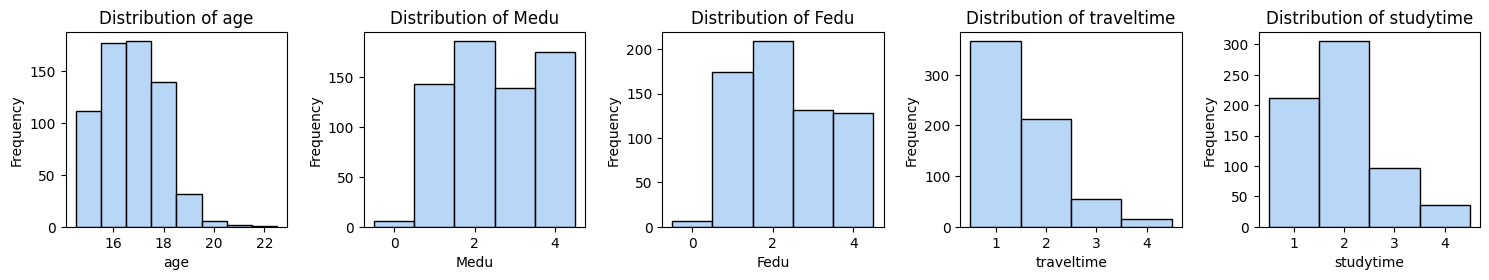

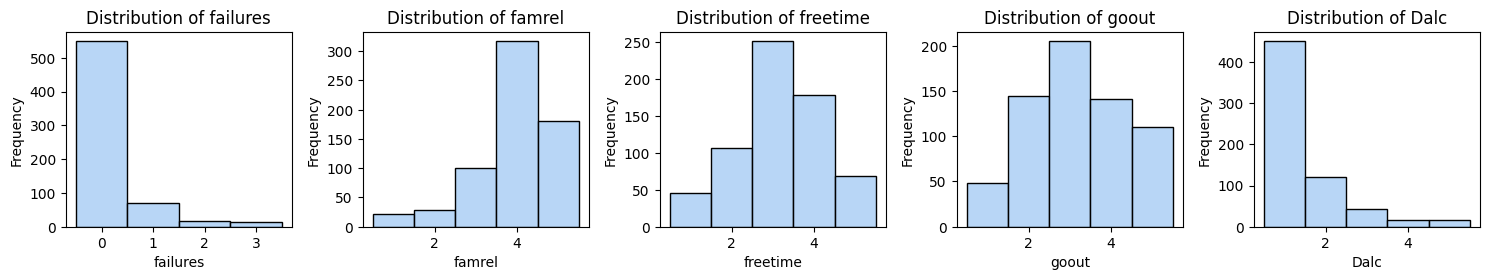

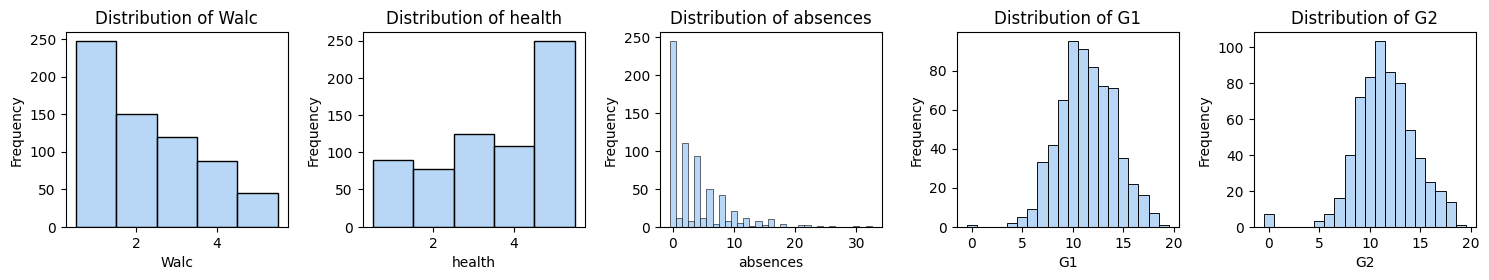

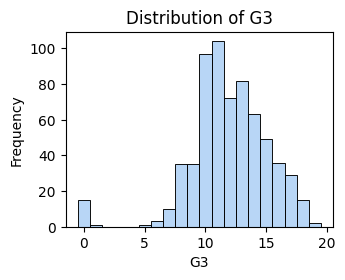

<Figure size 1500x500 with 0 Axes>

In [13]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

hist(df, numeric_columns)

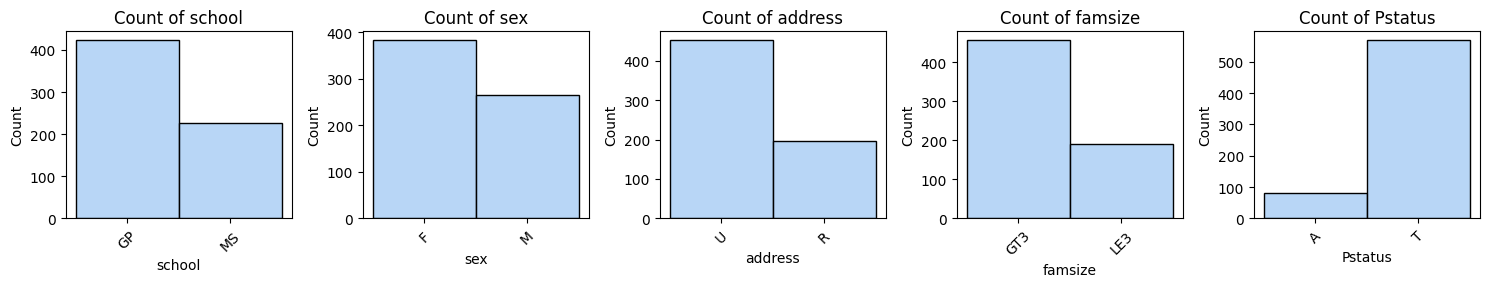

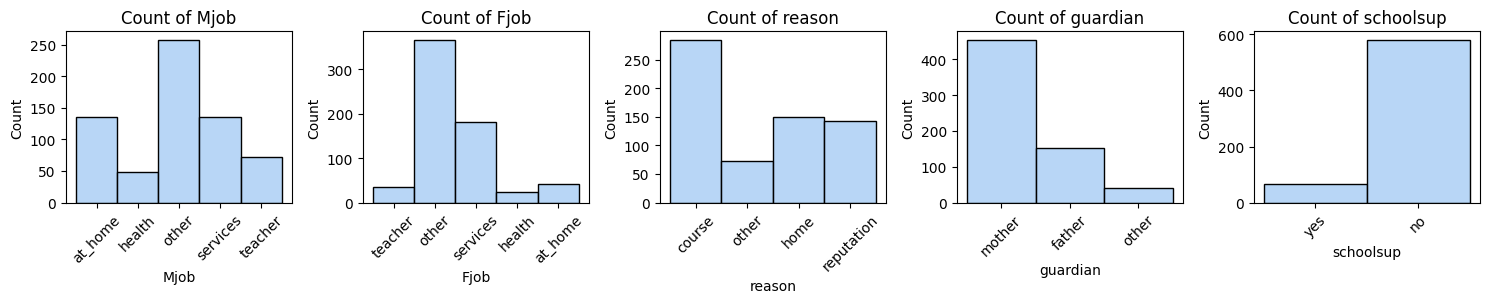

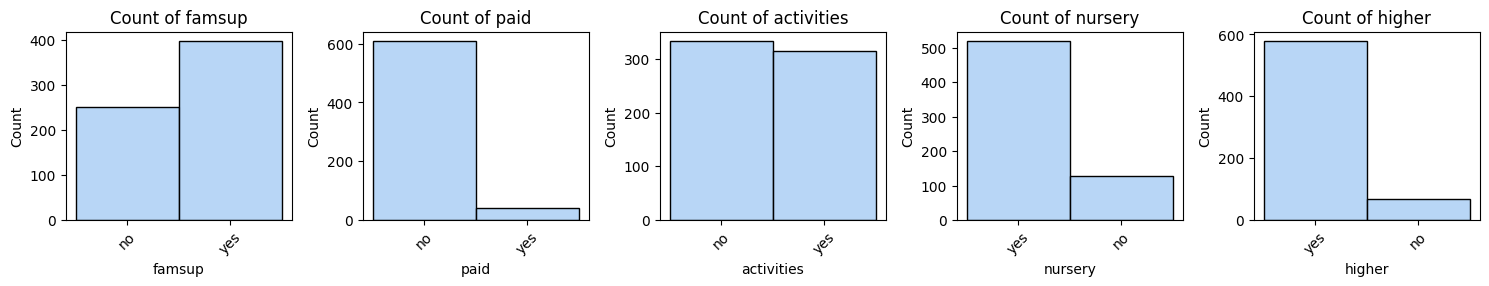

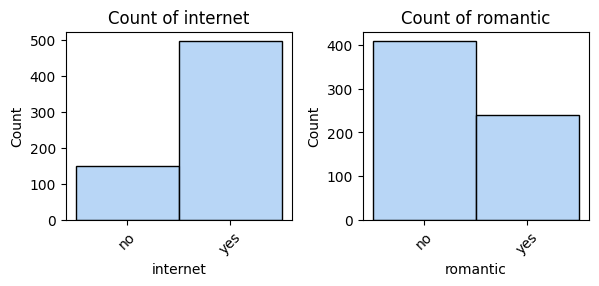

<Figure size 1500x500 with 0 Axes>

In [14]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

hist(df, categorical_columns, num_features=False)

Много мелочей можно подметить, таких как то, что присутсвует небольшая стратификация по полу и большая по дополнительным оплаченным занятиям, что у матерей несколько чаще встречается высшее образование, чем у отцов, что со студентами намного чаще занимаются матери, нежели отцы и тд и тп. Для нашего проекта важно, что распределения данных выглядят адекватно и с ними можно работать. Спасибо человеку, предоставившему такие опрятные данные, глаз радуется на них смотреть.


## Создание целевого признака, тренировочной и тестовой выборки

В датасет занесены данные об учениках Португальских школ. Согласно [таблицы конвертации оценок ERASMUS](https://www.gold.ac.uk/media/documents-by-section/staff-and-students/students/go-abroad/erasmus-conversion-tables.pdf) 20-бальная система оценок в Португалии переводится в 6-тибальную следующим образом:
* `A` - от 17 до 20
* `B` - от 14 до 16
* `C` - 12 и 13
* `D` - 11
* `E` - 10
* `F` - меньше 10

Построим распределение оценок, полученное таким образом.

In [15]:
def classify_grade_ERASMUS(grade):
    if grade >= 17:
        return 'A'
    elif grade in (14, 15, 16):
        return 'B'
    elif grade in (12, 13):
        return 'C'
    elif grade == 11:
        return 'D'
    elif grade == 10:
        return 'E'
    else:
        return 'F'

In [16]:
df['G3_5class'] = df['G3'].apply(lambda x: classify_grade_ERASMUS(x))

df['G3_5class'].value_counts().sort_index()

G3_5class
A     46
B    148
C    154
D    104
E     97
F    100
Name: count, dtype: int64

Довольно мало учеников с оценокй `A`. Позволим себе небольшую фривольность и сократим количество оценок до 5.

In [17]:
def classify_grade_custom(grade):
    if grade >= 16:
        return 'A'
    elif grade in (14, 15):
        return 'B'
    elif grade in (12, 13):
        return 'C'
    elif grade in (10, 11):
        return 'D'
    else:
        return 'E'

In [18]:
df['G3_5class'] = df['G3'].apply(lambda x: classify_grade_custom(x))

df['G3_5class'].value_counts().sort_index()

G3_5class
A     82
B    112
C    154
D    201
E    100
Name: count, dtype: int64

Так-то лучше. Выделим целевой признак, тренировочную и тестовые выборки, при этом обязательно укажем `stratify=y` в виду наличия дисбаланса классов, а `shuffle=True` установлен по умолчанию.

In [19]:
y = df['G3_5class']
X = df.drop(['G3',  'G3_5class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

##  Выбор метрики

Теперь подумаем над метрикой. Выбор будем делать между стандартными `accuracy` и `f1_macro`, не будем усложнять задачу `matthews_corrcoef` и `PR-AUC`. Что мы имеем:
1. Задачу мультиклассовой классификации
2. Дисбаланс классов

При этом нам не важна интерпетируемость метрики, ведь мы не собираемся объяснять результаты бизнесу, нам нужно только оценить работоспособность разработанных методов. Определённо выбираем `f1_macro`.

## Baseline

Далее, в идеале, нужно было бы показать, как обычно выглядит процесс разработки модели, чтобы потом сравнить с предложенными подходами. Однако это непомерно увеличило бы тетрадку. Покажем лишь небольшую часть, чтобы получить базовые значения метрик на кросс-валидации и тестовой выборке, с которыми в дальнейшем можно сверяться. В качестве базовой модели возьмём `LGBM`, потому что с ним проще всего работать. Вместо `cross_validate` используем `GridSearchCV`, который возвращает модель (которая нужна для тестовой метрики), чтобы написать чуть меньше кода.

In [20]:
model_LGBM = LGBMClassifier(verbose=-1, random_state=RANDOM_STATE)

stratified_kfold = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RANDOM_STATE)
grid_LGBM = GridSearchCV(model_LGBM, {}, cv=stratified_kfold, scoring="f1_macro")
grid_LGBM.fit(to_category_func(X_train), y_train)

pred_LGBM = grid_LGBM.predict(to_category_func(X_test))

grid_LGBM_cv_score = grid_LGBM.best_score_
grid_LGBM_test_score = f1_score(y_test, pred_LGBM, average="macro")

In [21]:
display(Markdown(f'f1_macro LGBM на кросс валидации: **{grid_LGBM_cv_score:.4f}**'))
display(Markdown(f'f1_macro LGBM на тестовой выборке: **{grid_LGBM_test_score:.4f}**'))

f1_macro LGBM на кросс валидации: **0.7336**

f1_macro LGBM на тестовой выборке: **0.6777**

Нормальное значение метрик, можно работать. Построим матрицу ошибок.

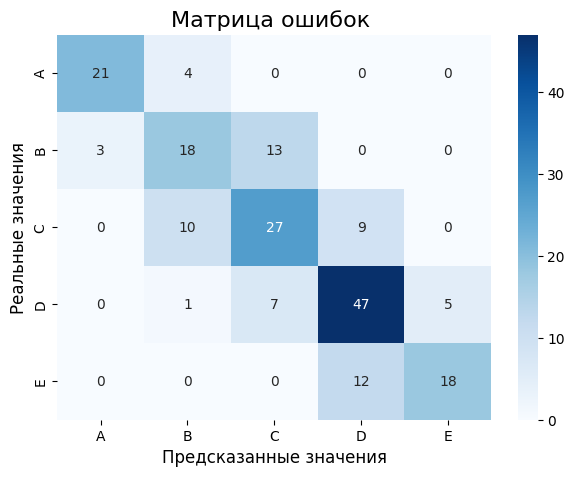

In [22]:
confusion_matrix_heatmap(y_test, pred_LGBM)

Радует, что проблемы только в разделении соседних классов. Плохо, что ошибок довольно много.

Бэйзлайн реализован. Отдельно хотелось бы посмотреть на важность признаков.

## Важность признаков

Важность признаков покажем с помощью `permutation_importance` на кросс-валидации.

In [23]:
result_pi_dict = permutation_importance_cv(model_LGBM,
                                           to_category_func(X_train),
                                           y_train,
                                           cv=CV,
                                           scoring='f1_macro',
                                           n_repeats=10,
                                           random_state=RANDOM_STATE,
                                           load_data=LOAD_DATA)

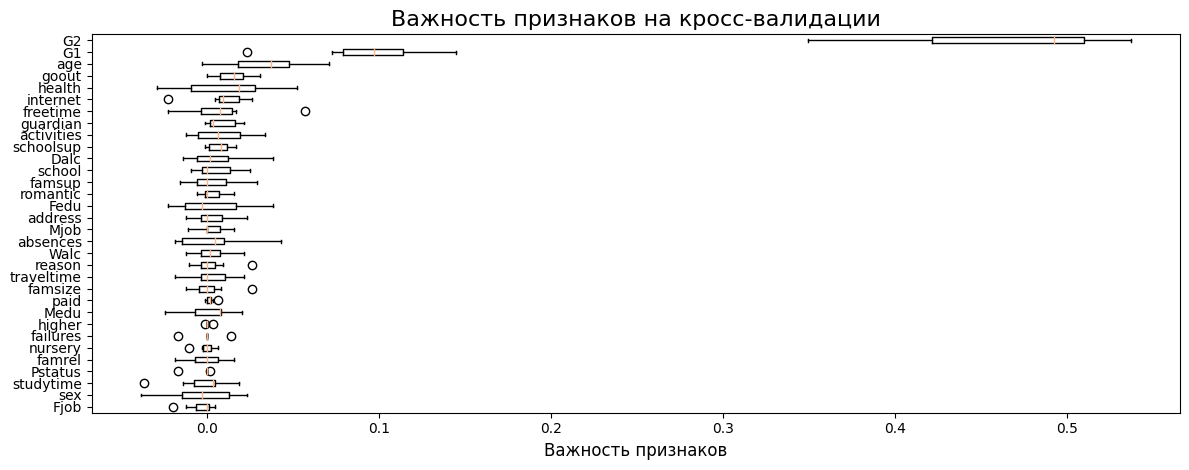

In [24]:
permutation_importance_graph(result_pi_dict, X_train)

Оценки за предыдущие этапы обучения дают очень сильную подсказку модели, что ожидаемо. Интересно, что следующим по важности идёт возраст. Посмотрим на этот признак в разрезе целевой переменной.

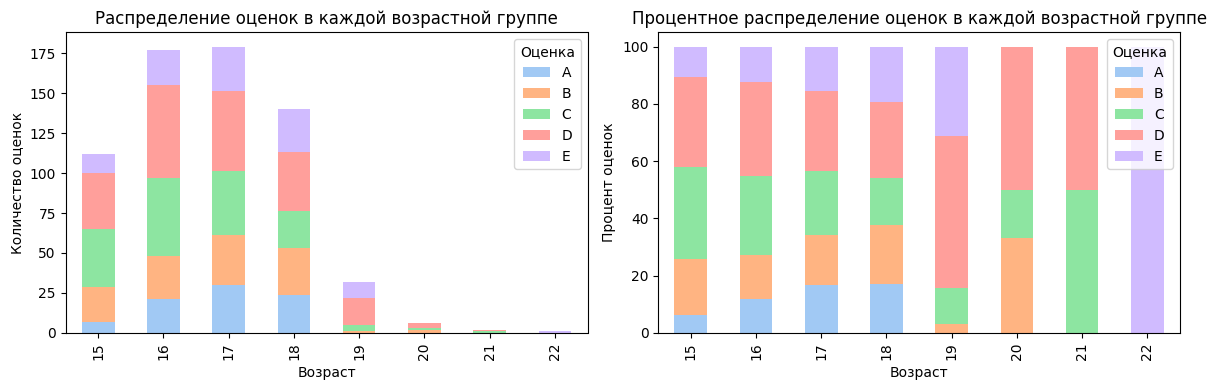

In [25]:
plot_grades_distribution(df, 'age', 'G3_5class')

Действительно с возрастом немного меняется срез оценок: становится больше в процентном соотношении крайних оценок `A` и `E` и меньше средней `C`. Можно предположить, что "взрослые" студенты лучше определяются с тем, нужна им учёба или нет и, соответственно, больше вкладываются и достигают лучших оценок, или наоборот, отдают предпочтение другим аспектам жизни, отчего страдает успеваемость.

Мы получили первые предсказания по нашим данным. А насколько наши предсказания "стабильны"?

## Бонус 1

Одна из проблем маленьких датасетов как наш - разбиение данных на тренировочную и тестовую выборки (в том числе и на кросс-валидации) может сильно влиять на метрику. Для уменьшения этого эффекта используются разные приёмы. В данной работе рассмотрим `StratifiedKFold`, `RepeatedKFold` и `LeaveOneOut`. Оценим каждый метод валидации, используя базовый `LGBMClassifier` и рассчитав метрики для 501 `RANDOM_STATE`, что с запасом превышает 384 - размер выборки для неограниченной генеральной совокупности с уровнем надежности 95% и погрешностью 5%.

In [26]:
def evaluate_on_RS(model, X, y, cv, random_states):

    test_indices = dict()
    results_test = dict()
    results_stratified_kfold = dict()
    results_repeated_kfold = dict()
    results_loo = dict()
    
    for RS in tqdm(random_states):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RS)
        test_indices[RS] = X_test.index

        X_train_cat = to_category_func(X_train)
        X_test_cat = to_category_func(X_test)
    
        model.fit(X_train_cat, y_train)
        
        # test metric
        pred = model.predict(X_test_cat)
        results_test[RS] = {'fit_time': 0, 'test_score':f1_score(y_test, pred, average="macro")}
    
        # stratified_kfold metric
        stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RS)
        results_stratified_kfold[RS] = cross_validate(model, X_train_cat, y_train, cv=stratified_kfold, scoring="f1_macro")
    
        # repeated_kfold metric
        repeated_kfold = RepeatedKFold(n_splits=cv, n_repeats=10, random_state=RS)
        results_repeated_kfold[RS] = cross_validate(model, X_train_cat, y_train, cv=repeated_kfold, scoring="f1_macro")
    
        # leave_one_out metric
        loo = LeaveOneOut()
        results_loo[RS] = cross_validate(model, X_train_cat, y_train, cv=loo, scoring="f1_macro")

    results = dict()
    methods = [test_indices, results_test, results_stratified_kfold, results_repeated_kfold, results_loo]
    methods_name = ['test_indices', 'results_test', 'results_stratified_kfold', 'results_repeated_kfold', 'results_loo']
    
    for method, method_name in zip(methods, methods_name):
        results[method_name] = method

    with open('../results/cv_research.pickle', 'wb') as f:
        pickle.dump(results, f)

    return test_indices, results_test, results_stratified_kfold, results_repeated_kfold, results_loo

In [27]:
def mean_on_RS_results(results):
    mean_results = dict()
    
    for RS, data in results.items():

        mean_results[RS] = {
            'fit_time': np.sum(data['fit_time']),
            'test_score': np.mean(data['test_score']),
            'test_score_mad': custom_mad(data['test_score'])
        }
    return mean_results

In [28]:
def methods_summary(results_dict):
    data = []
    columns = []

    for name, results in results_dict.items():
        metric_on_RS = []
        metric_var_on_RS = []
        time_on_RS = []

        for x in results.values():
            metric_on_RS.append(x['test_score'])
            metric_var_on_RS.append(x['test_score_mad'])
            time_on_RS.append(x['fit_time'])

            total_mean = np.mean(metric_on_RS).round(5)
            total_mad = custom_mad(metric_on_RS)
            mean_mad_on_RS = np.mean(metric_var_on_RS).round(5)
            total_time = np.mean(time_on_RS).round(3)

        data.append([total_mean, total_mad, mean_mad_on_RS, total_time])
        columns.append(name)

    df = pd.DataFrame(data, columns=['metric_mean', 'metric_mad', 'mean_mad_on_RS', 'time_per_RS'])
    
    df_swapped = df.transpose()
    df_swapped.columns = columns

    return df_swapped

In [29]:
def hist_box_plot(df_results):

    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    for metric in metrics:
        step = 0.01
        bin_min = min(df_results[metric].min(), df_results[metric].min())
        bin_max = max(df_results[metric].max(), df_results[metric].max()) + step
        counts, bins = np.histogram(df_results[metric], bins=np.arange(bin_min, bin_max, step))
        bin_centers = (bins[:-1] + bins[1:]) / 2
        plt.plot(bin_centers, counts, label=metric)
    
    test_654321 = df_results.loc[654321, 'test_metric']
    cv_654321 = df_results.loc[654321, 'stratified_kfold_metric']
    
    plt.axvline(x=test_654321, color='blue', linestyle='--', label='test RS=654321')
    plt.axvline(x=cv_654321, color='orange', linestyle='--', label='cv RS=654321')
    plt.text(test_654321, plt.gca().get_ylim()[1] - 20, 'test RS=654321', color='blue', va='top', ha='right')
    plt.text(cv_654321, plt.gca().get_ylim()[1] - 25, 'cv RS=654321', color='orange', va='top', ha='right')
    
    plt.xlabel('Среднее значение метрики')
    plt.ylabel(f'Количество в промежутке {step}')
    plt.title('Графики распределений средних значений метрик по каждому RS')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    sns.boxplot(data=df_results[metrics], orient='h')
    
    for i, metric in enumerate(metrics):
        median_val = df_results[metric].median().round(3)
        plt.text(median_val, i, f"{median_val}", color='black', ha='left', va='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='white', pad=3))
        
    plt.xlabel('Среднее значение метрики')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

In [30]:
def mean_on_RS_test(indices):
    
    index_mean = []
    index_std = []
    
    for RS, data in indices.items():
        
        index_mean.append(np.mean(data))
        index_std.append(np.std(data))

    return index_mean, index_std

In [31]:
def test_check(index_mean, index_std, df):

    theoretical_mean = df.shape[0] / 2
    theoretical_std = df.shape[0] / (2 * np.sqrt(3))
    
    plt.figure(figsize=(12, 3))
    
    plt.subplot(2, 1, 1)
    sns.boxplot(data=index_mean, orient='h')
    plt.axvline(x=theoretical_mean, color='red', linestyle='--', linewidth=1.5, label=f'Theoretical Mean: {theoretical_mean:.2f}')
    plt.legend(loc='upper right')
    plt.xlabel('Распределение средних значений индексов тестовых выборок')
    plt.title('Графики характеристик распределений в тестовых выборках')
    
    plt.subplot(2, 1, 2)
    sns.boxplot(data=index_std, orient='h')
    plt.axvline(x=theoretical_std, color='red', linestyle='--', linewidth=1.5, label=f'Theoretical std: {theoretical_std:.2f}')
    plt.legend(loc='upper right')
    plt.xlabel('Распределение стандартных отклонений индексов тестовых выборок')
    
    plt.tight_layout()
    plt.show()

Сгенерируем список наших `RANDOM_STATE`. Естественно случайных. Добавим к нему наш.

In [32]:
np.random.seed(RANDOM_STATE)
random_states = np.random.randint(0, 1000000, 500)
random_states = np.append(random_states, 654321)
print(random_states)

[259568 237056 465830 709887 856703 318635 242234 999582 460802 378357
 338550 565072 982113 115668 383163 211164 592111  34618 436244 862911
 778634 501341 836925 748893 331422 267558 977405 217886 879841 265632
 889998 295207 222034 558404 959490 209661 241200 949143 750043 349109
 216915 459998 661716  87805  82164 757730 457122  69075 425006 614929
 795408 498617 731234  61321 974923 497086 590387 406046 156496 245763
 711971 168679 141642 491336 258541 890441 415605 962620 410146 872813
  75726  70532 335894 565174 639009 547406 637563 445474 415498 479469
 214011 539902 200097 873780 464877 437186 846770 292495 559536  35697
 892255 435887  32749 335198 150115 326207 363447 280040 683844 342570
 744969 759683 426866 786402 948649 355230 140143 274965 533710 186265
 230159  75723 306790 781920 160808 174067 889694 579328 693199 572169
 822797  50465 308917   9192  18922 938062 583104  89119 539540 392637
 145867 466312 117983 623722  64301 880096 744938 705595 911709 869654
  3302

Для каждого `RANDOM_STATE` оценим модель указанными ранее способами. Так же проведём оценку простым разбиением на тестовую и тренировочную выборки и сохраним индексы тестовой выборки, чтобы убедиться, что индексы в тестовую выборку попадали равномерно. При этом не будем менять `RANDOM_STATE` в модели, чтобы исключить фактор влияния модели на исследование. Сохраним результаты в словарь `results`.

In [33]:
if LOAD_DATA:
    
    with open('../results/cv_research.pickle', 'rb') as f:
        results = pickle.load(f)

    test_indices = results['test_indices']
    results_test = results['results_test']
    results_stratified_kfold = results['results_stratified_kfold']
    results_repeated_kfold = results['results_repeated_kfold']
    results_loo = results['results_loo']
    
else:
    
    test_indices, results_test, results_stratified_kfold, results_repeated_kfold, results_loo = evaluate_on_RS(model_LGBM, X, y, CV, random_states)

Теперь нужно оценить результаты. Для этого подготовим функцию `custom_mad`, которая рассчитывает среднюю абсолютное отклонение в последовательности чисел.

In [34]:
def custom_mad(metric_values):
    return np.mean(np.abs(np.array(metric_values) - np.mean(metric_values))).round(5)

Извлечём из данных полезную информацию, относительно каждого RS:
1. Количество времени, ушедшее на выполнение оценки.
2. Среднее значение полученных метрик от каждого фолда.
3. Среднюю абсолютную отклонений метрик от каждого фолда.

In [35]:
mean_test = mean_on_RS_results(results_test)
mean_stratified_kfold = mean_on_RS_results(results_stratified_kfold)
mean_repeated_kfold = mean_on_RS_results(results_repeated_kfold)
mean_loo = mean_on_RS_results(results_loo)

Теперь интересно сравнить методы оценки моделей по следующим параметрам:
1. Средняя метрика по всем RS `metric_mean`, для сравнения методов по "оптимистичности / песиместичности" получаемой ими оценки.
2. Среднее абсолютное отклонение средних метрик всех RS `metric_mad` для оценки стабильности методов при изменении RS и, как следствие, изменении проведённого в начале исследования разбиения на `train-test`.
3. Среднее средних абсолютных отклонений метрик "внутри" RS, то есть по фолдам `mean_mad_on_RS` для оценки стабильонсти методов при фиксированном RS.
4. Среднее время выполнения метода.

In [36]:
results_dict = {'test':mean_test,
                'stratified_kfold': mean_stratified_kfold,
                'repeated_kfold': mean_repeated_kfold,
                'loo': mean_loo} 

methods_summary_df = methods_summary(results_dict)

methods_summary_df

,test,stratified_kfold,repeated_kfold,loo
metric_mean,0.71229,0.71029,0.70252,0.71598
metric_mad,0.02269,0.01566,0.01265,0.01524
mean_mad_on_RS,0.00000,0.04113,0.04419,0.40594
time_per_RS,0.00000,0.69900,7.03300,124.62500


`stratified_kfold` показал лучшую стабильность метрики при оценке на фолдах при фиксированном `RANDOM_STATE`, однако `repeated_kfold` показал наименьший разброс средних метрик по всем `RANDOM_STATE`. Метод `LeaveOneOut` показал самый большой разброс метрик и время расчёта.

Соберём все результаты в датасет.

In [37]:
all_results = {key: [mean_test[key]['test_score'],
                     mean_stratified_kfold[key]['test_score'],
                     mean_repeated_kfold[key]['test_score'],
                     mean_loo[key]['test_score'],
                     mean_test[key]['fit_time'],
                     mean_stratified_kfold[key]['fit_time'],
                     mean_repeated_kfold[key]['fit_time'],
                     mean_loo[key]['fit_time'],
                    ]
               for key in results_test}

In [38]:
metrics = ['test_metric', 'stratified_kfold_metric', 'repeated_kfold_metric', 'loo_metric']
columns = metrics + [f'{m}_time' for m in metrics]

df_results = pd.DataFrame.from_dict(all_results, orient='index', columns=columns)
df_results.head()

,test_metric,stratified_kfold_metric,repeated_kfold_metric,loo_metric,test_metric_time,stratified_kfold_metric_time,repeated_kfold_metric_time,loo_metric_time
259568,0.684040,0.683688,0.715151,0.733480,0,0.615477,6.682322,53.824697
237056,0.760643,0.679023,0.674124,0.693833,0,0.689071,6.419604,52.490800
465830,0.751727,0.671215,0.682663,0.702643,0,0.605550,6.300153,52.328963
709887,0.708112,0.738865,0.716527,0.720264,0,0.702474,6.542529,55.772389
856703,0.735811,0.679526,0.676801,0.674009,0,0.639582,6.674936,54.203984


И построим по нему графики распределений метрик каждого метода, отметив положение тестовой и кросс-валидационной метрик для нашего `RANDOM_STATE`.

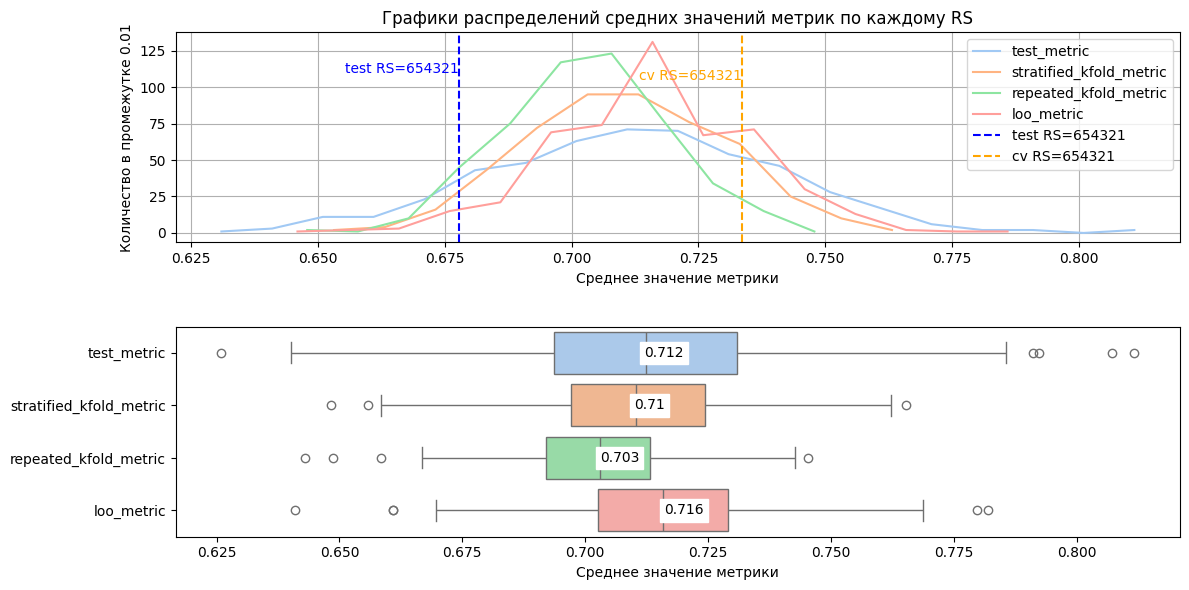

In [39]:
hist_box_plot(df_results)

Перед оформлением выводов проверим распределение индексов тестовой выборки и оценим его характеристики. Для этого посчитаем среднее и стандартное отклонение индексов в тестовой выборке по каждому `RANDOM_STATE`. Затем построим боксплоты по всем тестовым выборкам.

In [40]:
test_index_mean, test_index_std = mean_on_RS_test(test_indices)

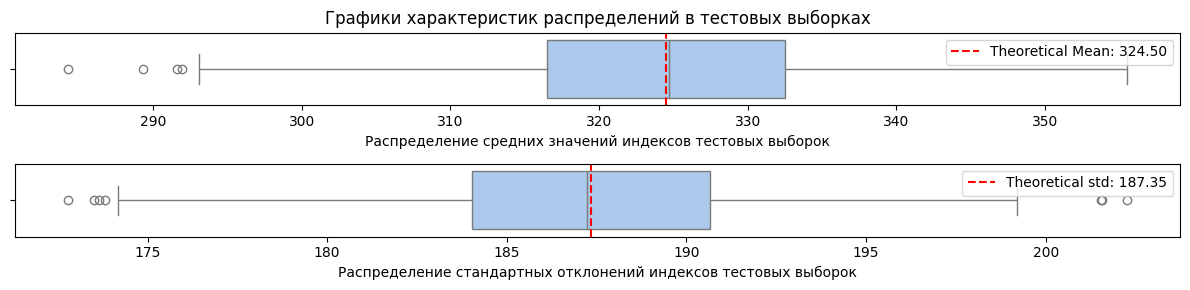

In [41]:
test_check(test_index_mean, test_index_std, df)

Можно заключить, что ...:
1. (опуская дополнительные выкладки) ...*распределение индексов тестовых выборок* достаточно случайно и равномерно, а смещение оценки невелико.
2. (по виду *графика распределения средних значений метрик по каждому RS*) ...501 `RANDOM_STATE` достаточно для оценки распределений.
3. ...метрики на тестовой выборке - самый нестабильный способ оценки, что логично, так как оценка проводится только по 30% данных
4. ...`StratifiedKFold` показал наименьший разброс метрик при оценке по фолдам - среднее отклонение **0.041**, в то время как `RepeatedKFold` показал наиболее стабильный результат при изменении `RANDOM_STATE` - **0.0126**. При этом `LeaveOneOut` оказался самым нестабильным методом оценки.

Теперь можно приступить к первой важной части проекта - разработка пайплайнов.

## Pipeline

### Идея раздела

Итак. Что мы хотим отобразить в этом разделе. Не все модели готовы работать с любыми данными. *Подача* данных в модели сопровождается некоторыми типовыми этапами, которые требуется выполнить для каждой модели независимо от проводимого исследования или вида самих данных. В данном разделе будет показано создание с помощью ООП подходов и библиотеки `pandas` типовых пайплайнов, которые в дальнейшем упростят подачу данных в модели и которые можно использовать в других исследованиях. Использование библиотеки `pandas`, и ориентированность на работу с датафреймами в частности, является недостатком предложенного подхода, который может привести к снижению скорости выполнения кода на больших данных, но показывает хороший результат на объёмах данных, соизмеримых с показанными в этом проекте. Возможно, в будущем `pandas` и `dataframe` будут заменены на `numpy.array` и `scipy.sparse.csc_matrix`.

Начнём с самой простой (но не по предобработке данных для обучения и тестирования) модели - `LogisticRegression`.

### LogisticRegression

Эта модель ребует масштабирование данных для числовых признаков и кодирование для категориальных. Выберем `StandardScaler` и `OneHotEncoder`. Казалось бы, всё просто. Но уже на этом этапе появляются две проблемы: <br>
1. Необходимость указывать в пайплайне какой трансформер к каким столбцам применяется. Если во время исследования один и тот же пайплайн используется для данных с разным названием, то нужно постоянно изменять названия переменных внутри пайплайна. <br>
2. `OneHotEncoder` откажется работать, если в столбце есть данные и числовых и строковых типов. Например `1`, `2` и `'1-2'`. Решается приведением столбца к строковом виду, при чём для категориальных столбцов не требуется отдельно анализировать данные в нём и решать, какой подход применить. Опять же, для разных датафреймов придется каждый раз применять функцию по преведению к строковому виду.

Так же `LogisticRegression` не работает с пропусками. Заполнение пропусков - действительно та задача, которая напрямую зависит от данных, поэтому автоматизировать её не будем, как не будет предлогать "базовое решение", например с заполнением `-1`. Лучше эту задачу оставить *явно не решённой*.

А теперь вопрос: если мы передаём тренировочные данные в пайплайн, то почему эти действия с ними нельзя выполнить внутри пайплайна? И тогда, один раз создав пайплайн, можно не переживать о переменных с числовыми и категориальными столбцами и приведению нужных столбцов к строковому типу. Вообще-то можно, если использовать видоизменённый `ColumnTransformer` со следующими методами:
1. При инициализации объявим две переменные `self.categorical_columns` и `self.numerical_columns`, в которых будут категориальные и числовые столбцы соответственно.
3. В методе `fit` определим, какие столбцы к какой категории `self.categorical_columns` или `self.numerical_columns` относятся, предварительно преобразовав их в `dataframe` (иначе `select_dtypes` не работает).
4. С помощью методов `cat_feature` и `num_feature` будем возвращать списки столбцов из `fit`, чтобы потом передавать их нужный трансформер.
5. Так же объявим метод `transform`, который вызывается внутри пайплайна, для приведения категориальных столбцов к единому строковому типу, снова преобразовав полученные фичи в `dataframe`.

Напишем же код.

In [42]:
class CustomColumnTransformer(BaseEstimator, TransformerMixin):
    """
    Пользовательский трансформер для обработки категориальных и числовых признаков в данных.
    
    Атрибуты:
    categorical_columns: Список столбцов, содержащих категориальные признаки.
    numerical_columns: Список столбцов, содержащих числовые признаки.
    """
    
    def init(self):
        self.categorical_columns = None
        self.numerical_columns = None

    def fit(self, X, y=None):
        """
        Определяет категориальные и числовые столбцов во входных данных.
        
        Аргументы:
        X (array-like): Входные данные
        
        Возвращает:
        self: Возвращает экземпляр трансформера
        """
        X_df = pd.DataFrame(X)
        self.categorical_columns = X_df.select_dtypes(include=['category', 'object']).columns.tolist()
        self.numerical_columns = X_df.select_dtypes(include=[np.number]).columns.tolist()
        return self
        
    def cat_feature(self, X):
        """
        Получает список категориальных столбцов признаков.
        
        Аргументы:
        X (array-like): Входные данные
        
        Возвращает:
        list: Список имен столбцов, содержащих категориальные признаки
        """
        self.fit(X)
        return self.categorical_columns

    def num_feature(self, X):
        """
        Получает список числовых столбцов признаков.
        
        Аргументы:
        X (array-like): Входные данные
        
        Возвращает:
        list: Список имен столбцов, содержащих числовые признаки
        """
        self.fit(X)
        return self.numerical_columns
        
    def transform(self, X):
        """
        Преобразует категориальные столбцы в тип 'str'.
        
        Аргументы:
        X (array-like): Входные данные
        
        Возвращает:
        pandas DataFrame: Трансформированные данные с категориальными столбцами в формате 'str'
        """
        self.fit(X)
        X_df = pd.DataFrame(X).copy()
        X_df[self.categorical_columns] = X_df[self.categorical_columns].astype('str')
        return X_df

Теперь создадим пайплайн, чтобы продемонстрировать работу метода `CustomColumnTransformer`. Первый шаг пайплайна `custom_transformer` - приведение категориальных столбцов к строковому типу. Просто используем экземпляр класса `CustomColumnTransformer()` `data_transformer`, ведь пайплайн самостоятельно вызовет его метод `transform`. Второй шаг `preprocessor_LR` - препроцессинг данных с `OneHotEncoder()` и `StandardScaler()`. Для определения числовых и категориальных столбцов для трансформеров используем `data_transformer.cat_feature` и `data_transformer.num_feature` без вызова, потому что нам нужно передать туда `X` не при создании пайплайна, а только при вызове этих методов внутри пайплайна. Не будем использовать `remainder="passthrough"`, ведь все столбцы должны пройти наш препроцессинг. Третий шаг - `LogisticRegression()`.

In [43]:
data_transformer = CustomColumnTransformer()

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
standard_scaler = StandardScaler()

model_LR = LogisticRegression(random_state=RANDOM_STATE)

In [44]:
categorical_transformer_LR = Pipeline(steps=[
            ('OneHotEncoder', one_hot_encoder)
    ])          
        
numerical_transformer_LR = Pipeline(steps=[
            ('StandardScaler', standard_scaler)
    ])
        
preprocessor_LR = ColumnTransformer(
        transformers=[
            ("preprocessor_cat", categorical_transformer_LR, data_transformer.cat_feature),
            ("preprocessor_num", numerical_transformer_LR, data_transformer.num_feature),
        ]
    )
    
pipeline_LR = Pipeline(
        steps=[
            ("data_transformer", data_transformer),
            ("preprocessor", preprocessor_LR),
            ("clf", model_LR),
        ]
    )

pipeline_LR

Pipeline(steps=[('data_transformer', CustomColumnTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <bound method CustomColumnTransformer.cat_feature of CustomColumnTransformer()>),
                                                 ('preprocessor_num',
                                                  Pipeline(steps=[('StandardScaler',
                                                                   StandardScaler())]),
                                                  <bound method CustomColumnTransformer.num_feature of CustomColumnTransformer()>)])),
                ('clf', LogisticRegression(random_state=654321))])

Отлично, проверим функционал. Для проверки `CustomColumnTransformer.transform()` заменим `other` на 0 в наших данных.

In [45]:
X_train.replace('other', 0, inplace=True)
X_test.replace('other', 0, inplace=True)

X_train.Mjob.unique()

array(['services', 0, 'teacher', 'at_home', 'health'], dtype=object)

In [46]:
grid_pipeline_LR = GridSearchCV(pipeline_LR, {}, cv=stratified_kfold, scoring="f1_macro")
grid_pipeline_LR.fit(X_train, y_train)

display(Markdown(f'f1_macro pipeline_LR на кросс валидации: **{grid_pipeline_LR.best_score_:.4f}**'))

f1_macro pipeline_LR на кросс валидации: **0.6216**

Работает. Отлично, идём дальше. `RandomForest`.

### RandomForest

С ним попроще и имеющегося функционала `CustomColumnTransformer` достаточно. Используем `OrdinalEncoder()` вместе с `data_transformer.cat_feature` и `remainder="passthrough"`, так как числовые столбцы у нас не используются в `preprocessor_RFC` и проходят мимо. Так же потребуется приведение столбцов к строковому типу с помощью `data_transformer`. 

In [47]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

model_RFC = RandomForestClassifier(random_state=RANDOM_STATE)

In [48]:
categorical_transformer_RFC = Pipeline(steps=[
            ('OrdinalEncoder', ordinal_encoder),
    ])

preprocessor_RFC = ColumnTransformer(
        transformers=[
            ("preprocessor_cat", categorical_transformer_RFC, data_transformer.cat_feature)
        ],
        remainder="passthrough",
    )

pipeline_RFC = Pipeline(
        steps=[
            ("data_transformer", data_transformer),
            ("preprocessor", preprocessor_RFC),
            ("clf", model_RFC),
        ]
    )

pipeline_RFC

Pipeline(steps=[('data_transformer', CustomColumnTransformer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('preprocessor_cat',
                                                  Pipeline(steps=[('OrdinalEncoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <bound method CustomColumnTransformer.cat_feature of CustomColumnTransformer()>)])),
                ('clf', RandomForestClassifier(random_state=654321))])

In [49]:
grid_pipeline_RFC = GridSearchCV(pipeline_RFC, {}, cv=stratified_kfold, scoring="f1_macro")
grid_pipeline_RFC.fit(X_train, y_train)

display(Markdown(f'f1_macro pipeline_RFC на кросс валидации: **{grid_pipeline_RFC.best_score_:.4f}**'))

f1_macro pipeline_RFC на кросс валидации: **0.7013**

И это работает. `LGBM`.

### LGBM

Он, как и остальные два наших бустинга, не требует масштабирования числовых при знаков и кодировки категориальных, однако нужно приведести столбцы типа `object` к типу `category`, как это было показано ранее. Выполнение этого действия упрощает работу с категориальными фичами, убирая необходимость прямого их указывания при создании модели. Добавим в `CustomColumnTransformer` новый метод `to_cat()`, выполняющий это действие и поместим его в пайплайн с помощью `FunctionTransformer`.

In [50]:
def to_category(self, X):
    """
    Преобразует категориальные столбцы в тип 'category'.
        
    Аргументы:
    X (array-like): Входные данные
        
    Возвращает:
    X_copy: Копия входных данных с преобразованными категориальными столбцами
    """
    X_copy = X.copy()
    self.fit(X_copy)
    X_copy[self.categorical_columns] = X_copy[self.categorical_columns].astype('category')
    return X_copy

In [51]:
CustomColumnTransformer.to_category = to_category

data_transformer = CustomColumnTransformer()

model_LGBM = LGBMClassifier(verbose=-1, random_state=RANDOM_STATE)

In [52]:
transformer_LGBM = FunctionTransformer(data_transformer.to_category)
    
pipeline_LGBM = Pipeline(
        steps=[
            ('transformer', transformer_LGBM),
            ("clf", model_LGBM),
        ]
    )

pipeline_LGBM

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<bound method to_category of CustomColumnTransformer()>)),
                ('clf', LGBMClassifier(random_state=654321, verbose=-1))])

In [53]:
grid_pipeline_LGBM = GridSearchCV(pipeline_LGBM, {}, cv=stratified_kfold, scoring="f1_macro")
grid_pipeline_LGBM.fit(X_train, y_train)

display(Markdown(f'f1_macro pipeline_LGBM на кросс валидации: **{grid_pipeline_LGBM.best_score_:.4f}**'))

f1_macro pipeline_LGBM на кросс валидации: **0.7336**

Отлчино, теперь `XGB`.

### XGB

С ним придётся повозиться. Изначальная ситуация как и с `LGBM`. Однако, `XGB` единственный из всех моделей (даже `LogisticRegression` с этим справляется) не любит, когда формат целевой переменной отличается от формата "целые числа от нуля включительно". Какие варианты? Для его одного создавать новый список тренировочных и тестовых целевых переменных? Тогда будут проблемы потом, когда, например, захотим в цикле построить матрицы ошибок для всех моделей. Для всех моделей создавать новый список тренировочных и тестовых целевых переменных? Тогда мы потеряем красивые названия признаков и придётся где-то держать как числовое пространство целевых признаков соотносится с исходным текстовым. Давайте и это занесем в пайплайн. Причём мы хотим кодировать признаки для обучения `XGB` и декодировать их обратно для предсказаний. Одна проблема - `Pipeline` из `sklearn.pipeline` не работает с `y`, хотя разработчиков [давно об этом просят](https://github.com/scikit-learn/scikit-learn/issues/20952). На помощь нам придёт `Pipeline` из `imblearn.pipeline`. Он предназначен для работы с несбалансированными данными, которые предполагают ресемплинг, который, в свою очередь, предпалагает изменение `y`. То есть в этом пайплайне можно дотянуться до целевой переменной, чтобы её изменить. Обозначим необходимый функционал:
1. Кодировка текстовых признаков для `XGB` c помощью `LabelEncoder` для обучения. Поместим это в метод `fit_resample` нового класса, который будет вызываться пайплайном перед обучением.
2. Декодировка числовых признаков обратно в текстовые для предсказаний. А вот тут придётся повозиться. `Pipeline` не предполагает работы с выходящими из модели предсказаниями. Видимо и `Pipeline` придётся изменить, чтобы переопределить метод `predict`.

Создадим класс `target_encode`. В нём создадим метод `fit_resample`, в котором будет обучаться `LabelEncoder`, а возвращаться преобразованный `y` вместе с неизменённым `X`, как того требует `imblearn.pipeline`. Добавим метод `inverse_transform_target` для обратной декодировки признаков.

In [54]:
class TargetEncoder():
    """
    Класс target_encode предназначен для кодирования и декодирования целевой переменной с использованием LabelEncoder.
    """

    def __init__(self):
        self.le = LabelEncoder()

    def fit_resample(self, X, y):
        """
        Обучает LabelEncoder на целевой переменной y и кодирует её.

        Параметры:
        X : массив признаков
        y : целевая переменная

        Возвращает:
        X : массив признаков
        y_encoded : закодированная целевая переменная
        """
        self.le.fit(y)
        y_encoded = self.le.transform(y)
        return X, y_encoded
    
    def inverse_transform_target(self, y_encoded):
        """
        Декодирует закодированную целевую переменную обратно в исходные значения.

        Параметры:
        y_encoded : закодированная целевая переменная

        Возвращает:
        Исходные значения целевой переменной
        """
        return self.le.inverse_transform(y_encoded)

Теперь нам есть что положить в `predict` для `CustomPipeline`, чтобы переопределить этот метод. Получим предсказания через `super().predict(X)` и декодируем их обратно, используя обученный при обучении (-_-) `LabelEncoder` в `target_encode`, обратившись к нему по названию шага, на котором произошло обучение `LabelEncoder`.

In [55]:
class CustomPipeline_XGB(Pipeline):
    """
    Класс CustomPipeline_XGB представляет собой настраиваемую версию класса Pipeline, специфичную для использования с моделью XGBoost.

    Этот класс добавляет к классу Pipeline метод predict, который возвращает декодированные предсказания целевой переменной.
    """

    def predict(self, X):
        """
        Предсказывает целевую переменную для входных данных X с использованием модели. Декодирует кодированные предсказания обратно в исходные значения.

        Parameters:
        X : массив признаков

        Returns:
        y_pred : декодированные предсказания целевой переменной
        """

        y_pred_encoded = super().predict(X)
        y_pred = self.named_steps['target_encode'].inverse_transform_target(y_pred_encoded)
        return y_pred

Соберём всё в пайплайн.

In [56]:
target_encoder = TargetEncoder()

model_XGB = XGBClassifier(random_state=RANDOM_STATE, verbose=0, enable_categorical=True)

In [57]:
transformer_XGB = FunctionTransformer(data_transformer.to_category)

pipeline_XGB = CustomPipeline_XGB(
        steps=[
            ('to_cat', transformer_XGB),
            ('target_encode', target_encoder),
            ("clf", model_XGB),
        ]
    )

pipeline_XGB

CustomPipeline_XGB(steps=[('to_cat',
                           FunctionTransformer(func=<bound method to_category of CustomColumnTransformer()>)),
                          ('target_encode',
                           <__main__.TargetEncoder object at 0x000002E43165E760>),
                          ('clf',
                           XGBClassifier(base_score=None, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=...
                                         gamma=None, grow_policy=None,
                                         importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=None, max_bin=None,
                                         max_cat_threshold=None,
                                         max_cat_to_onehot=None,
                                         max_delta_step=None, max_depth=None,
                                         max_leaves=None, min_child_weight=None,
                                         missing=nan, monotone_constraints=None,
                                         multi_strategy=None, n_estimators=None,
                                         n_jobs=None, num_parallel_tree=None,
                                         random_state=654321, ...))])

In [58]:
grid_pipeline_XGB = GridSearchCV(pipeline_XGB, {}, cv=stratified_kfold, scoring="f1_macro")
grid_pipeline_XGB.fit(X_train, y_train)
pred_pipeline_XGB = grid_pipeline_XGB.predict(X_train)

display(Markdown(f'f1_macro pipeline_XGB на кросс валидации: **{grid_pipeline_XGB.best_score_:.4f}**'))
display(Markdown(f'Пример предсказаний pipeline_XGB: {pred_pipeline_XGB[:10]}'))

f1_macro pipeline_XGB на кросс валидации: **0.7153**

Пример предсказаний pipeline_XGB: ['A' 'D' 'C' 'B' 'C' 'B' 'C' 'C' 'E' 'B']

И это работает. Ура! Остался `CatBoost`.

### CatBoost

Самая неприхотливая модель и наши стандартные методы подготовки к обучению ей не нужны, то есть пайплайн в таком виде ей не нужен, но мы создадим для сохранения общего вида всех моделей. При этом `CatBoost` требует явной передачи списка категориальных признаков. Это автоматизировать мне не удалось. Хотя можно было бы создать `Custom_CatBoostClassifier`, но надо знать, когда остановиться...

In [59]:
cat_columns = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

model_CB = CatBoostClassifier(iterations=10, verbose=0, random_state=RANDOM_STATE, cat_features=cat_columns)

In [60]:
pipeline_CB = Pipeline(
        steps=[
            ("clf", model_CB),
        ]
    )

pipeline_CB

Pipeline(steps=[('clf',
                 <catboost.core.CatBoostClassifier object at 0x000002E431696940>)])

In [61]:
grid_pipeline_CB = GridSearchCV(pipeline_CB, {}, cv=stratified_kfold, scoring="f1_macro")
grid_pipeline_CB.fit(X_train, y_train)

display(Markdown(f'f1_macro pipeline_CB на кросс валидации: **{grid_pipeline_CB.best_score_:.4f}**'))

f1_macro pipeline_CB на кросс валидации: **0.7334**

Пайплайны с моделями готовы.

### Итоги раздела

Теперь у нас есть независимые от данных и самостоятельные пайплайны для пяти наших моделей, которым в `fit()` можно подавать что угодно (если пропуски были заполнены отдельно, как было сказано ранее) и получать на выходе наши метки классов. Функциональность кода проверена, код разбит на смысловые блоки и его удобно импортировать в другие проекты.

Какой следующий шаг в ML? Правильно, подбор гиперпараметров. В этом нам поможет `optuna`.

## optuna

### Идея раздела

Основная идея этого раздела - сократить количество кода в тетрадке, вынеся типовые решения в отдельный файл. Важно отметить: разработчик понимает, что представленный ниже код имеет ограниченную функциональность и существуют другие, более гибкие подходы к подбору гиперпараметров, такие как интеграция оптуны в `lgb` или встроенные методы у `catboost`. В целом хочется сказать, что всего сразу не охватить. Освоение библиотеки `optuna` уже хороший шаг по сравнению с использованием `GridSearchCV` и `RandomizedSearchCV`. Если по пунктам, то приведённый ниже код будет пополняться при появлении необходимости использвания нового функционала `optuna` (если конечно общение напрямую с оптуной не будет удобнее). А исследование библиотек бустингов будет следующим шагом. Конкретно сейчас есть необходимость закрыть базовые потребности в **ML** в проектах, чтобы освободить время для изучения других вещей.

Далее будет показано поэтапное создание класса `CustomOptuna`, в котором будет реализован необходимый функционал.

### `CustomOptuna`

Определим класс `CustomOptuna` и опишем его инициализацию непосредственно в коде, не будем дублировать описание переменных в ячейках `Markdown`. Из особенностей:
1. `n_jobs` - использование ядер процессора для оптуны. По умолчанию - `1` (как в самой оптуне). Все ядра - -1. Однако не удалось решить проблему со случайными результатами оптуны при установке -1, поэтому не рекомендуется пользоваться этим параметром. Так как задача [потенциально решаема](https://stackoverflow.com/questions/78158918/reproducible-results-of-optuna-when-n-jobs-1), то было принято решение оставить этот параметр.
2. Дополним инициализацию класса проверкой переданных значений. Если `n_trials` или `interval` будут меньше нуля, а `timeout` меньше или равен нулю - выведем сообщение об ошибке и прекратим выполнение кода. Для `n_jobs != 1` и неуказанного `random_state` просто выведем сообщение о том, что результаты могут отличаться.

In [62]:
class CustomOptuna:
    """
    Класс CustomOptuna представляет собой настраиваемый класс для оптимизации гиперпараметров с использованием библиотеки Optuna.

    Параметры
    ---------
    n_trials : int, default=100
        Количество пробных запусков для оптимизации.
        
    timeout : int, default=180
        Временной лимит на выполнение оптимизации.
        
    cv : int, default=7
        Количество фолдов для кросс-валидации для оценки набора гипер-параметров.
        
    interval : int, default=100
        Количество иттераций для остановки расчёта, если не было улучшений метрики.
        
    n_jobs : int, default=1
        Количество процессорных ядер, используемых параллельно для оптимизации.
        
    random_state : int, default=None
        Случайное состояние для воспроизводимости результатов.
        
    is_pipeline : bool, default=True
        Флаг, указывающий, используется ли класс Pipeline.
        
    show_progress_bar : bool, default=True
        Флаг для отображения прогресс-бара в процессе оптимизации.
        
    early_stopping_callback : bool, default=True
        Флаг для использования функции ранней остановки.
        
    scorer : str, default='f1_macro'
        Метрика для оценки качества модели во время оптимизации.

    Ошибки
    ------
    Если n_trials меньше или равен нулю, выбрасывается исключение ValueError.
    Если timeout меньше нуля, выбрасывается исключение ValueError.
    Если interval меньше или равен нулю, выбрасывается исключение ValueError.
    Если n_jobs не равен 1, отображается предупреждение о возможном отличии результатов.
    Если random_state равен None, отображается предупреждение о возможном отличии результатов.
    """
    
    def __init__(self, n_trials=100, timeout=180, cv=7, interval=100, n_jobs=1, random_state=None, 
                 is_pipeline=True, show_progress_bar=True, early_stopping_callback=True, scorer='f1_macro'):
        
        self.n_trials = n_trials
        self.timeout = timeout
        self.cv = cv
        self.show_progress_bar = show_progress_bar
        self.early_stopping_callback = early_stopping_callback
        self.interval = interval
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.is_pipeline = is_pipeline
        self.scorer = scorer
        
        if self.n_trials <= 0:
            raise ValueError("n_trials должен быть отрицательным числом")

        if self.timeout < 0:
            raise ValueError("timeout не может быть положительным числом")

        if self.interval <= 0:
            raise ValueError("interval должен быть отрицательным числом")

        if self.n_jobs != 1:
            display(Markdown("**Результаты выполнения optuna могут отличаться из-за n_jobs != 1**"))
            
        if self.random_state == None:
            display(Markdown("**Результаты выполнения optuna могут отличаться из-за random_state == None**"))

Следующий важный объект - `objective`. Он используется для оценки модели с выбранным набором гиперпараметров.

### `objective`

В классе `Objective` на понадобится описать:
1. Его инициализацию `__init__`, при которой в него будут передаваться необходимые переменные.
2. Вызов `__call__`, в котором будет проходить обновление параметров модели и оценка набора гиперпараметров на кросс-валидации. Если `is_pipeline` имеет значение `True`, то обновлять параметры модели в пайплайне будем следующим образом: `model.steps[-1][1].set_params(**hpspace(trial))`, предполагая, что модель находится на последнем шаге. Иначе используем стандартный `model.set_params(**hpspace(trial))`
3. Функцию `BestModelCallback`, которая будет отвечать за сохранение лучшей модели в `self.best_model_`.

In [63]:
class Objective:
    
    """
    Класс Objective используется для оптимизации гиперпараметров модели.

    Параметры
    ----------
    model : object
        Модель  для оптимизации.
    X : array-like
        Признаки модели.
    y : array-like
        Целевая переменная модели.
    hpspace : function
        Функция, возвращающая пространство гиперпараметров для оптимизации.
    cv : int
        Количество фолдов для кросс-валидации.
    scorer : str
        Метрика для оценки качества модели во время оптимизации.
    random_state : int
        Случайное состояние для воспроизводимости.
    is_pipeline : bool
        Флаг, указывающий является ли модель пайплайном.

    Атрибуты
    --------
    best_model_ : object, по умолчанию=None
        Лучшая модель после оптимизации.
    """
    
    def __init__(self, model, X, y, hpspace, cv, scorer, random_state, is_pipeline):
        """
        Инициализирует экземпляр класса Objective с переданными параметрами.
        """
        self.model = model
        self.X = X
        self.y = y
        self.hpspace = hpspace
        self.cv = cv
        self.scorer = scorer
        self.random_state = random_state
        self.is_pipeline = is_pipeline
        self.best_model_ = None
        
    def __call__(self, trial):
        """
        Основной метод для оптимизации модели.
        """
        if self.is_pipeline:
            self.model.steps[-1][1].set_params(**self.hpspace(trial))
        else:
            self.model.set_params(**self.hpspace(trial))

        stratified_kfold = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)
        scores = cross_val_score(self.model, self.X, self.y, scoring=self.scorer, cv=stratified_kfold)

        return np.mean(scores)

    def BestModelCallback(self, study, trial):
        """
        Callback-метод для определения лучшей модели после оптимизации.
        """
        if study.best_trial.number == trial.number:
            self.best_model_ = self.model

In [64]:
CustomOptuna.Objective = Objective

Следующим шагом будем создание класса `EarlyStoppingCallback`, который будет прекращать работу оптуны, если оценочная метрика не увеличивалась определённое число иттераций.

### `EarlyStoppingCallback`

При инициализации нам нужен только `interval`. При вызове будем сравнивать `study.best_trial.number` с `trial.number`и если разница больше `interval`, то вызовем `study.stop()`.

In [65]:
class EarlyStoppingCallback:
    """
    Класс обратного вызова для ранней остановки изучения (study) в оптимизации гиперпараметров.

    Параметры
    ---------
    interval : int
        Интервал для ранней остановки. Если разница в номерах между текущим испытанием (trial) 
        и лучшим испытанием (best_trial) больше этого интервала, изучение прекращается.
    """
    def __init__(self, interval):
        """
        Инициализирует экземпляр класса EarlyStoppingCallback с переданными параметрами.
        """
        self.interval = interval
        
    def __call__(self, study, trial):
        """
        Метод, который вызывается для проверки условия ранней остановки и при необходимости прекращает изучение.

        Параметры
        ---------
        study : объект Study
            Объект исследования, содержащий информацию о текущем исследовании.
        trial : объект Trial
            Текущее испытание, для которого проверяется условие ранней остановки.
        """
        best_trial = study.best_trial
        if trial.number - best_trial.number > self.interval:
            study.stop()

In [66]:
CustomOptuna.EarlyStoppingCallback = EarlyStoppingCallback

Последний большой шаг перед запуском подбора гиперпараметров - задание этих гиперпараметров.

### `hpspaces_default`

Создадим функцию `hpspaces_default`, в которой будут находиться параметры, которые можно использовать по умолчанию. Внутри создадим функции, определяющие пространства гиперпараметров для каждой модели, поместим их в словарь, и будем возвращать нужное пространство по ключу в виде названия модели.

In [67]:
def hpspaces_default(self, model):
    """
    Возвращает пространство поиска гиперпараметров по умолчанию для указанной модели.

    Параметры:
    - model: объект модели

    Возвращает функцию с настройками гиперпараметров для указанной модели.
    """

    def hpspace_LR_default(trial):
        """
        Возвращает пространство поиска гиперпараметров для LogisticRegression.

        Параметры:
        - trial: объект Trial

        Возвращает словарь с параметрами модели LogisticRegression.
        """
        return {
                'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']),
                'random_state': self.random_state
            }

    def hpspace_RFC_default(trial):
        """
        Возвращает пространство поиска гиперпараметров для RandomForestClassifier.

        Параметры:
        - trial: объект Trial

        Возвращает словарь с параметрами модели RandomForestClassifier.
        """
        return {
                'max_depth' : trial.suggest_int('max_depth', 2, 10),
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
                'n_estimators' : trial.suggest_int('n_estimators', 25, 200),
                'criterion': 'entropy',
                'random_state': self.random_state
            }

    def hpspace_LGBM_default(trial):
        """
        Возвращает пространство поиска гиперпараметров для LGBMClassifier.

        Параметры:
        - trial: объект Trial

        Возвращает словарь с параметрами модели LGBMClassifier.
        """
        return {
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
                'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
                'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
                'verbose': -1,
                'random_state': self.random_state
            }

    def hpspace_XGB_default(trial):
        """
        Возвращает пространство поиска гиперпараметров для XGBClassifier.

        Параметры:
        - trial: объект Trial

        Возвращает словарь с параметрами модели XGBClassifier.
        """
        return {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
                'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
                'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 10.0),
                'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
                'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
                'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
                'verbosity': 0,
                'seed': self.random_state
            }

    def hpspace_CB_default(trial):
        """
        Возвращает пространство поиска гиперпараметров для CatBoostClassifier.

        Параметры:
        - trial: объект Trial

        Возвращает словарь с параметрами модели CatBoostClassifier.
        """
        return {
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
                'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
                'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 10.0),
                'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-8, 10.0),
                'border_count': trial.suggest_int('border_count', 32, 255),
                'random_state':self.random_state,
                'verbose': False
            }

    params = {'LogisticRegression': hpspace_LR_default,
              'RandomForestClassifier': hpspace_RFC_default,
              'LGBMClassifier': hpspace_LGBM_default,
              'XGBClassifier': hpspace_XGB_default,
              'CatBoostClassifier': hpspace_CB_default}

    if self.is_pipeline:
        name_model = model.steps[-1][1].__class__.__name__
    else:
        name_model = model.__class__.__name__
        
    return params[name_model]

In [68]:
CustomOptuna.hpspaces_default = hpspaces_default

Теперь можно приступать к запуску `study.optimize`.  Для этого соберём предыдущие наработки вместе в функции `study_optimize`.

### `study_optimize`

Результатом выполнения `study.optimize` является объект `Study` с лучшим набором гиперпараметров. Его и будем возвращать из `study_optimize`. Для этого нам понадобится выполнить следующие шаги:
1. Скопировать `model` через `deepcopy` в `optuna_mode` и работать дальше с `optuna_model`, чтобы не менять изначальную модель.
2. Провести проверку значения переменной `self.early_stopping_callback`. Создадим пустой список `callbacks` и если при инициализации `CustomOptuna` была указана необходимость ранней остановки, то добавим в этот список `self.EarlyStoppingCallback()` с `self.interval`. Иначе передадим `None`.
3. Проверить значение переменной `hpspace`. Если гиперпараметры не переданы, то использовать гиперпараметры по умолчанию.
4. Создадим экземпляр класса `self.Objective` в `self.objective_to_study`. Передадим в него переменные `model`, `X`, `y`, `hpspace`, которые нужно указать при объявлении `study_optimize`. Все остальные переменные, используемые в `study_optimize` можно взять из `self`, так как они задаются при инициализации `CustomOptuna` один раз.
5. Не забыть про сохранение лучшей модели и добавить в `callbacks` метод `BestModelCallback` из `self.objective`.
6. Cоздать `optuna.create_study` c указанием `seed` и `direction='maximize'` (возможно в будущем стоит добавить переменную при инициализации, для настройки этой опции).
7. Запустить `study.optimize`.
8. Вернуть `study`.

In [69]:
def study_optimize(self, model, X, y, hpspace=None):
    """
    Метод для оптимизации модели.

    Параметры
    ---------
    model : object
        Обучаемая модель, которую необходимо оптимизировать.
    X : array-like
        Матрица признаков для обучения модели.
    y : array-like
        Целевая переменная для обучения модели.
    hpspace : dict
        Пространство поиска гиперпараметров модели.

    Возвращает
    ----------
    study : object
        Объект Study после завершения оптимизации.
    """
    
    optuna_model = deepcopy(model)
    callbacks = []
    study = None

    if self.early_stopping_callback:
        callbacks.append(self.EarlyStoppingCallback(self.interval))

    if hpspace:
        self.hpspace = hpspace
    else:
        self.hpspace = self.hpspaces_default(optuna_model)

    self.objective_to_study = self.Objective(optuna_model, X, y, self.hpspace, self.cv, self.scorer, self.random_state, self.is_pipeline)
    callbacks.append(self.objective_to_study.BestModelCallback)
    
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=self.random_state), direction='maximize')
    study.optimize(self.objective_to_study, n_trials=self.n_trials, timeout=self.timeout, n_jobs=self.n_jobs, callbacks=callbacks, show_progress_bar=self.show_progress_bar)

    return study

In [70]:
CustomOptuna.study_optimize = study_optimize

После получения `study` можно вывести результаты выполнения оптуны. Создадим для этого функцию `optuna_results`. 

### `optuna_results`

Нас интересует лучшая метрика, которая хранится в `study.best_trial.value` и лучший набор гиперпараметров из `study.best_params`. Возвращать будем `''`, чтобы вместо `None` выводилась пустая строка.

In [71]:
def optuna_results(self, study):
    """
    Функция для отображения результатов оптимизации.

    Параметры
    ---------
    study : object
        Объект Study, содержащий результаты оптимизации.

    Возвращает
    ----------
    Вывод результатов обучения.
    Пустая строка.
    """
    
    display(Markdown(f'Лучшая метрика: {study.best_trial.value:.4}'))
    display(Markdown(f'Лучший набор гиперпараметров: {study.best_params}'))
    
    return ''

In [72]:
CustomOptuna.optuna_results = optuna_results

Основной блок можно считать выполненым. Посмотрим, как он работает на примере `pipeline_LGBM`.

### Проверка `CustomOptuna`

Создадим оценщик `f1_macro_scorer`.

In [73]:
def f1_macro_func(y_true, y_pred):
    """
    Функция вычисляет метрику F1-оценки с усреднением по макросреднему. 
    
    Параметры
    ---------
    - y_true: истинные значения целевой переменной
    - y_pred: предсказанные значения целевой переменной
    Возвращает
    ----------
    Значение F1-оценки с усреднением по макросреднему.
    """
    
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    return f1_macro_score

In [74]:
f1_macro_scorer = make_scorer(f1_macro_func)

Иницализируем экземпляр класса `CustomOptuna` в переменную `custom_optuna_pipe`.

In [75]:
custom_optuna_pipe = CustomOptuna(n_trials=N_TRIALS, timeout=TIMEOUT, cv=CV, interval=INTERVAL, random_state=RANDOM_STATE, scorer=f1_macro_scorer)

Запустим `study_optimize`, сохранив результаты в study_pipe.

In [76]:
study_pipe = custom_optuna_pipe.study_optimize(pipeline_LGBM, X_train, y_train)

  0%|          | 0/3 [00:00<?, ?it/s]

Выведем результаты обучения на экран с помощью `optuna_results`

In [77]:
print(custom_optuna_pipe.optuna_results(study_pipe))

Лучшая метрика: 0.7354

Лучший набор гиперпараметров: {'class_weight': None, 'boosting_type': 'gbdt', 'lambda_l1': 0.0006981417604555845, 'lambda_l2': 6.014735094618799e-05, 'num_leaves': 131, 'feature_fraction': 0.8672712668576954, 'bagging_fraction': 0.8342284545402874, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 17, 'learning_rate': 0.03265495983273885}

Выведем лучшую модель из `self.best_model_`.

In [78]:
best_model_pipe = custom_optuna_pipe.objective_to_study.best_model_
best_model_pipe

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<bound method to_category of CustomColumnTransformer()>)),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.7235618955438218,
                                bagging_freq=7, boosting_type='dart',
                                class_weight='balanced',
                                feature_fraction=0.7646682480556555,
                                lambda_l1=0.01235011832856817,
                                lambda_l2=5.056897538374584,
                                learning_rate=0.3898013215242188, max_depth=17,
                                min_child_samples=15, num_leaves=43,
                                random_state=654321, verbose=-1))])

In [79]:
best_model_pipe.steps[1][1].get_params()

{'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3898013215242188,
 'max_depth': 17,
 'min_child_samples': 15,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 43,
 'objective': None,
 'random_state': 654321,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'lambda_l1': 0.01235011832856817,
 'lambda_l2': 5.056897538374584,
 'feature_fraction': 0.7646682480556555,
 'bagging_fraction': 0.7235618955438218,
 'bagging_freq': 7}

Ранняя остановка сработала, параметры модели в пайплайне обновились, пока всё работает. Протестируем метрику на кросс-валидации.

In [80]:
stratified_kfold = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(pipeline_LGBM, X_train, y_train, scoring=f1_macro_scorer, cv=stratified_kfold)
display(Markdown(f'Метрика лучшей модели на кросс валидации: **{np.mean(scores):.6f}**'))

Метрика лучшей модели на кросс валидации: **0.733634**

Отлично, метрика та же. Проверим работу других параметров: используем не пайплайн, уберём раннюю остановку, `RANDOM_STATE` и `scorer`, передадим свои гиперпараметры `hpspace_LGBM`, не забыв применить `to_category` к `X_train`.

In [81]:
def hpspace_LGBM(trial):
    """
    Возвращает пространство поиска гиперпараметров для LGBMClassifier.

    Параметры:
    - trial: объект Trial

    Возвращает словарь с параметрами модели LGBMClassifier.
    """
    return {
                    'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
                    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
                    'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
                    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
                    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
                }

In [82]:
model_LGBM = LGBMClassifier(verbose=-1)

custom_optuna_test = CustomOptuna(n_trials=N_TRIALS, timeout=TIMEOUT, cv=CV, is_pipeline=False, early_stopping_callback=False)
study_test = custom_optuna_test.study_optimize(model_LGBM, to_category_func(X_train), y_train, hpspace=hpspace_LGBM)

print(custom_optuna_test.optuna_results(study_test))

**Результаты выполнения optuna могут отличаться из-за random_state == None**

  0%|          | 0/3 [00:00<?, ?it/s]

Лучшая метрика: 0.7349

Лучший набор гиперпараметров: {'class_weight': None, 'boosting_type': 'gbdt', 'lambda_l1': 2.6282834896112308e-05, 'lambda_l2': 1.571658302169297e-08, 'num_leaves': 220, 'feature_fraction': 0.8348375671786943, 'bagging_fraction': 0.9697832243050875, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 17, 'learning_rate': 0.05795725275394918}

In [83]:
best_model_test = custom_optuna_test.objective_to_study.best_model_
best_model_test.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05795725275394918,
 'max_depth': 17,
 'min_child_samples': 66,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 220,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'lambda_l1': 2.6282834896112308e-05,
 'lambda_l2': 1.571658302169297e-08,
 'feature_fraction': 0.8348375671786943,
 'bagging_fraction': 0.9697832243050875,
 'bagging_freq': 7}

Предупреждения получены, параметры модели обновлены. Не считая блока с параметрами, удалось сократить количество кода в тетрадке от объявления оптуны до получения рабочей модели до трёх (без дополнительного вывода результатов - до двух) строчек. Напоследок посмотрим, как выглядит использование `CustomOptuna` из файла.

### Импорт из файла 

In [84]:
from custom_optuna import CustomOptuna

In [85]:
def hpspace_LGBM(trial):
    """
    Возвращает пространство поиска гиперпараметров для LGBMClassifier.

    Параметры:
    - trial: объект Trial

    Возвращает словарь с параметрами модели LGBMClassifier.
    """
    return {
                    'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
                    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
                    'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
                    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
                    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
                }

In [86]:
pipeline_LGBM

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<bound method to_category of CustomColumnTransformer()>)),
                ('clf', LGBMClassifier(random_state=654321, verbose=-1))])

In [87]:
custom_optuna = CustomOptuna(n_trials=N_TRIALS, timeout=TIMEOUT, cv=CV, interval=INTERVAL, random_state=RANDOM_STATE, scorer=f1_macro_scorer)
study = custom_optuna.study_optimize(pipeline_LGBM, X_train, y_train, hpspace=hpspace_LGBM)

  0%|          | 0/3 [00:00<?, ?it/s]

In [88]:
print(custom_optuna.optuna_results(study))

Лучшая метрика: 0.7354

Лучший набор гиперпараметров: {'class_weight': None, 'boosting_type': 'gbdt', 'lambda_l1': 0.0006981417604555845, 'lambda_l2': 6.014735094618799e-05, 'num_leaves': 131, 'feature_fraction': 0.8672712668576954, 'bagging_fraction': 0.8342284545402874, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 17, 'learning_rate': 0.03265495983273885}

In [89]:
best_model = custom_optuna.objective_to_study.best_model_

best_model

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<bound method to_category of CustomColumnTransformer()>)),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.7235618955438218,
                                bagging_freq=7, boosting_type='dart',
                                class_weight='balanced',
                                feature_fraction=0.7646682480556555,
                                lambda_l1=0.01235011832856817,
                                lambda_l2=5.056897538374584,
                                learning_rate=0.3898013215242188, max_depth=17,
                                min_child_samples=15, num_leaves=43,
                                random_state=654321, verbose=-1))])

*Да, кросс валидация для модели уже была проведена, но не хочется подглядывать в тестовую выборку, поэтому просто ещё раз проверим, правильно ли всё работет*

In [90]:
results_best_model = cross_validate(best_model, X_train, y_train, cv=stratified_kfold, scoring="f1_macro")
mean_f1_macro_best_model = results_best_model["test_score"].mean()

In [91]:
display(Markdown(f'Среднее значение f1_macro LGBM с подобранными оптуной гиперпараметрами на кросс-валидации: **{mean_f1_macro_best_model:.4f}**'))

Среднее значение f1_macro LGBM с подобранными оптуной гиперпараметрами на кросс-валидации: **0.7159**

### Итоги раздела

Разработан, проверен и вынесен в отдельный файл класс `CustomOptuna`, позволяющий провести быстрый подбор гиперпараметров.

## Бонус 2. Stacking

### Идея раздела

Второй бонусный раздел посвящён сбору самого большого пайплайна с помощью `StackingClassifier`. Минимум смысловой нагрузки, максимум веселья.

### Подготовка

Возьмём наши лучшие модели и сделаем их базовыми классификаторами, передав в `estimators` в `StackingClassifier`.

In [92]:
#optuna_LR = optuna_best_pipelines['LogiscticRegression']
#optuna_RFC = optuna_best_pipelines['RandomForestClassifier'] 
#optuna_LGBM = optuna_best_pipelines['LGBMClassifier']
#optuna_XGB = optuna_best_pipelines['XGBClassifier']

optuna_LR = pipeline_LR
optuna_RFC = pipeline_RFC
optuna_LGBM = pipeline_LGBM
optuna_XGB = pipeline_XGB

estimators = [
     ('LR', optuna_LR),
     ('RFC', optuna_RFC),
     ('LGBM', optuna_LGBM),
     ('XGB', optuna_XGB),  
 ]

Для полного раскрытия возможностей наших пайплайнов, финальному классификатору помимо предсказаний базовых моделей будем передавать и сами данные. Одна проблема - `StackingClassifier` передаёт на вход финальному классификатору `numpy.ndarray`, с которым не работает наш `CustomColumnTransformer`. Ещё один повод перейти на `numpy.array`. А пока установим заглушку - класс `DataType`, который из `numpy.ndarray` будет создавать `dataframe` с указанием правильных типов данных в столбце. Обернём эти действия в функцию `transform`, которая будет вызываться пайплайном при обучении и предсказаниях. 

In [93]:
class DataType:
    """
    Класс для преобразования типов данных в датафрейме.
    
    Методы
    ------
    - fit(self, X, y=None): обучение, требуется для пайплайна.
    - transform(self, X): преобразование типов данных в датафрейме.
    
    Атрибуты
    --------
    - X: датасет для преобразования типов данных.
    - y: целевая переменная (не используется в данном классе).
    """
    
    def fit(self, X, y=None):
        """Обучение модели, не требуется для данного класса."""
        return self

    def transform(self, X):
        """
        Преобразует типы данных столбцов в датасете X.
        
        Параметры:
        - X: датасет, в котором нужно преобразовать типы данных
        
        Возвращает:
        - df: датафрейм с преобразованными типами данных
        """
        df = deepcopy(pd.DataFrame(X))
        for col in df.columns:
            unique_values = df[col].unique()
            if all(isinstance(val, str) for val in unique_values):
                df[col] = df[col].astype(str)
            elif all(isinstance(val, int) for val in unique_values):
                df[col] = df[col].astype(int)
            elif all(isinstance(val, float) for val in unique_values):
                df[col] = df[col].astype(float)
            else:
                df[col] = df[col].astype(str)
        return df

Финальную модель сделаем пайплайном, с кучей разных фичей. В роли классификатора используем `RandomForestClassifier`, чтобы не увеличивать количество признаков `OneHotEncoder`'ом. В препроцессинг поместим `categorical_transformer_RFC` для преобразования категориальных переменных и `numerical_transformer_LR` для масштабирования числовых (вообще говоря не обязательно). Добавим удаление выбросов, немного доработав `IsolationForest`, после этого удалим коррелирующие признаки с помощью `DropCorrelatedFeatures`, выберем лучшие с помощью `SelectKBest` и проведём апсемплинг `ADASYN`.

In [94]:
preprocessor_top = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer_RFC, CustomColumnTransformer().cat_feature),
            ("num", numerical_transformer_LR, CustomColumnTransformer().num_feature),
        ]
    )

In [95]:
class IsolationForestTransformer(IsolationForest):
    """
    Класс-трансформер на основе Isolation Forest для удаления выбросов в данных.

    Методы
    ------
    - init(self, contamination=0.1, random_state=None, kwargs): инициализация модели Isolation Forest с определенными параметрами
    - fit_resample(self, X, y): обучение модели и удаление выбросов из данных

    Атрибуты
    --------
    - X: признаки для обучения модели
    - y: целевая переменная для обучения модели
    """
    
    def __init__(self, contamination=0.1, random_state=None, **kwargs):
        """
        Инициализация модели Isolation Forest с заданными параметрами.

        Параметры
        ---------
        - contamination: уровень аномалий в данных
        - random_state: для воспроизводимости результата
        - kwargs: дополнительные параметры для Isolation Forest
        """
        super().__init__(**kwargs)
        self.model = IsolationForest(contamination=contamination, random_state=random_state)

    def fit_resample(self, X, y):
        """
        Обучение модели на данных X и удаление выбросов.

        Параметры
        ---------
        - X: признаки для обучения модели
        - y: целевая переменная для обучения модели

        Возвращает
        ----------
        - X_clean: признаки без выбросов
        - y_clean: соответствующие целевые переменные без выбросов
        """
        self.fit(X)
        y_pred = self.predict(X)
        X_clean = X[y_pred == 1]
        y_clean = y[y_pred == 1]
        return X_clean, y_clean

In [96]:
def my_score(X, y):

    """
    Функция скоринга для SelectKBest
    """

    return mutual_info_classif(X, y, random_state=RANDOM_STATE)

In [97]:
pipeline_top = Pipeline(
        steps=[
            ('data_transformer', DataType()),
            ("preprocessor", preprocessor_top),
            ('isolation_forest', IsolationForestTransformer(random_state=RANDOM_STATE, contamination=0.05)),
            ('drop_correlated', DropCorrelatedFeatures(method='spearman', threshold=0.8)),
            ('select_k_best', SelectKBest(score_func=my_score, k=40)),
            ('ADASYN', ADASYN(random_state=RANDOM_STATE, n_neighbors=2)),
            ("clf", RandomForestClassifier(random_state=RANDOM_STATE)),
        ]
    )

Пайплайн для `final_estimator` готов, соберём весь `StackingClassifier`.

### `StackingClassifier`

In [98]:
SC = StackingClassifier(
                            estimators=estimators,
                            final_estimator=pipeline_top,
                            stack_method='predict_proba',
                            cv=stratified_kfold,
                            passthrough=True
                           )

Выведем же его.

In [99]:
SC

StackingClassifier(cv=StratifiedKFold(n_splits=7, random_state=654321, shuffle=True),
                   estimators=[('LR',
                                Pipeline(steps=[('data_transformer',
                                                 CustomColumnTransformer()),
                                                ('preprocessor',
                                                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                                                  Pipeline(steps=[('OneHotEncoder',
                                                                                                   OneHotEncoder(drop='first',
                                                                                                                 handle_unknown='ignore',
                                                                                                                 sparse_output=False))]),
                                                                                  <bound meth...
                                                    IsolationForestTransformer(contamination='auto')),
                                                   ('drop_correlated',
                                                    DropCorrelatedFeatures(method='spearman')),
                                                   ('select_k_best',
                                                    SelectKBest(k=40,
                                                                score_func=<function my_score at 0x000002E42F4528B0>)),
                                                   ('ADASYN',
                                                    ADASYN(n_neighbors=2,
                                                           random_state=654321)),
                                                   ('clf',
                                                    RandomForestClassifier(random_state=654321))]),
                   passthrough=True, stack_method='predict_proba')

: )

Оценим на кросс-валидации.

In [100]:
results_SC = cross_validate(SC, X_train, y_train, cv=stratified_kfold, scoring="f1_macro")

In [101]:
f1_cv_SC = results_SC["test_score"].mean()

display(Markdown(f'Среднее значение f1_macro стэккинга на кросс-валидации: **{f1_cv_SC:.4f}**'))

Среднее значение f1_macro стэккинга на кросс-валидации: **nan**

И даже метрика получилась, значит всё должно работать нормально.

Вернёмся к нашему проекту. Последняя задача - реализовать метод one-vs-rest с возможностью подключения `CustomOptuna`.

## one-vs-rest

### Идея раздела

Как уже было сказано ранее, здесь мы хотим объединить решение задачи мультиклассовой классификации по принципу `one-vs-rest` и подбор гиперпараметров для каждой модели создав свой аналог `sklearn.OneVsRestClassifier` со встроенной `CustomOptuna`.

### `OneVsRestClassifier`

Изначальная идея заключалась в том, чтобы инициализировать `CustomOptuna` непосредственно внутри `OneVsRestClassifier`, передавая в экземпляр класса `OneVsRestClassifier` все нужные для оптуны аргументы. Однако в последствии было решено разделить инициализацию этих классов. Поэтому теперь `OneVsRestClassifier` имеет только три аргумента:
1. `model`, через который будет передаваться модель.
2. `optuna`, через который будет передаваться экземпляр класса `CustomOptuna` при необходимости подбора гиперпараметров. По умолчанию `optuna` имеет значение `False`.
3. `hpspace` с гиперпараметрами для оптуны.
4. Так же объявим словарь `best_models`, в котором по ключу в виде класса будут расположены лучшие модели. Объявлять этот словарь нужно именно здесь, чтобы в дальнейшем его удобно извлекать из экземпляра класса `OneVsRestClassifier`.
5. И сразу создадим `__repr__`, чтобы не выводилась информация о расположении объекта в памяти.

In [102]:
class OneVsRestClassifier():
    def __init__(self, model, optuna=False, hpspace=None):
        
        self.model = model
        self.optuna = optuna
        self.hpspace = hpspace
        self.best_models = {}

    def __repr__(self):
        return "OneVsRestClassifier()"

Класс есть, теперь опишем обучение классификатора. Проверять `OneVsRestClassifier` будем сразу из файла, поэтому не будем добавлять наши методы в `OneVsRestClassifier`, а просто покажем и опишем их.

### `ovr_fit`

Для обучения в качестве аргументов нужно указать `X` и `y` и создать переменную `self.y`, чтобы обращаться к ней в других методах, в которых `y` явно не передаеётся. Всё. Остальное возьмём из `self`. Само обучение будет выглядеть следующим образом:
1. Создадим цикл, в котором будем перебирать классы из `sorted(self.y.unique())`.
2. Проверим соответствие каждого объекта из `y` выбранному классу. Все другие классы зануляются.
3. Так как в итоге у нас будет несколько моделей, то скопируем переданную в `OneVsRestClassifier` модель с помощью `deepcopy`. Далее будем работать с копией.
4. Если при инициализации `OneVsRestClassifier` был передан экземпляр класса `CustomOptuna`, то выполним подбор гиперпараметров.
5. Обучим модель.
6. Добавим в `best_models` по ключу в виде метки класса обученную модель.
7. Возвращать будем `self`. Приём, подсмотренный у моделей из `sklearn`.

In [103]:
def ovr_fit(self, X, y):
    
    self.y = y
    custom_optuna = self.optuna

    for current_class in sorted(self.y.unique()):
        y_train_single_class = np.where(self.y == current_class, 1, 0)
            
        model_copy = deepcopy(self.model)
    
        if self.optuna:
            study = custom_optuna.study_optimize(model_copy, X, y_train_single_class, self.hpspace)
            model_copy = custom_optuna.objective_to_study.best_model
                        
        model_copy.fit(X, y_train_single_class)
        self.best_models[str(current_class)] = model_copy        

    return self

Модели обучены, теперь можно получить предсказания.

### `ovr_predict_proba`

Сначала получим вероятности классов, так как их основе легко получить и сами классы. Соберём предсказания таким же иттерированием по `sorted(self.y.unique())`. Для каждого класса извлечём из `best_models` свою модель, вызовем `predict_proba`, возьмём предсказания класса `1` с помощью `[:,1]` и запишем в датафрейм `result`. Так же добавим возможность нормализации вероятностей. Ненормализованные вероятности могут показать те объекты, которые плохо определяются всеми моделями, если, например, все вероятности будут малы. При этом нормализованные вероятности удобнее воспринимать. 

In [104]:
def ovr_predict_proba(self, X, normalized=False):

    self.result = pd.DataFrame(index=X.index)

    for current_class in sorted(self.y.unique()):
        
        model = self.best_models[str(current_class)]
        self.result[str(current_class)] = model.predict_proba(X)[:,1]

    if normalized:
        self.result = self.result.div(self.result.sum(axis=1), axis=0) 
        
    return self.result

Вероятности есть, теперь метки классов.

### `ovr_predict`

Будем выбирать класс с наибольшей вероятностью с помощью `idxmax(axis=1)`.

In [105]:
def ovr_predict(self, X):
    
    proba = self.ovr_predict_proba(X)
    
    return proba.idxmax(axis=1)

### `ovr_cv`

К сожалению, предложенные выше подходы не позволяют передать экземпляр `OneVsRestClassifier` в `cross_validate` от `sklearn`, потому что при каждом вызове метода `fit` будет подбираться новый набор гиперпараметров, . Но оценивать метод кросс-валидацией нужно, поэтому напишем для этого свой метод `ovr_cv`. Рассматривалась возможность доработки методов `ovr_fit` и `ovr_predict` 

Доработка методов `ovr_fit` и `ovr_predict` для передачи в `cross_validate` от `sklearn` требует довольно больших затрат по времени. Написать свою кросс-валидацию, и уже для неё дорабатывать `ovr_fit` и `ovr_predict` проще, но, к сожалению, этот подход успехом не увенчался. Поэтому напишем  полностью код кросс-валидации `ovr_cv`.

1. В качестве аргументов нам понадобятся признаки `X` и целевая переменная `y`, переменная `stratified_kfold` для передачи кросс-валидатора и оценщик `scorer`.
2. Проведём проверку значения переменной `stratified_kfold`, а так же проверим, был ли вызван метод `ovr_fit` для заполнения `self.best_models`.
3. В цикле будем проводить разбиение в соответствии с переданным в `cv` значением.
4. Позаимствуем подходы из `ovr_fit`, извлекая из `self.best_models` модель и обучая её копию на тренировочных фолдах.
5. Предсказания на тестовых фолдах будем собирать без `dataframe`, сразу в `np.array`, поэтому будем получать не исходные метки классов, а позицию в `sorted(y_train.unique())`.
6. Проведём маппинг классов из `y` и предсказанных позиций в `sorted(y_train.unique())`.
7. Сохраним оценку в `scores` и после завершения цикла по фолдам вернём `scores`.

In [106]:
def ovr_cv(self, X, y, stratified_kfold, scorer='f1_score'):

    scores = np.array([])

    if not isinstance(stratified_kfold, StratifiedKFold):
        raise ValueError("stratified_kfold должен быть объектом StratifiedKFold")

    if len(self.best_models) == 0:
        raise ValueError("Сначала выполните ovr_fit")

    for train_index, test_index in stratified_kfold.split(X, y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        predictions = np.array([])

        for current_class in sorted(y_train.unique()):
            y_train_single_class = np.where(y_train == current_class, 1, 0)

            model_copy = deepcopy(self.best_models[f"{current_class}"])
            model_copy.fit(X_train, y_train_single_class)

            predictions = np.append(predictions, model_copy.predict_proba(X_test)[:, 1])
            
        predicted_classes = np.argmax(predictions.reshape(len(y_test.unique()), -1), axis=0)
        
        mapping_dict = dict(zip(list(range(len(y_train))), sorted(y_train.unique())))
        predicted_classes_mapped = [mapping_dict[val] for val in predicted_classes]

        scores = np.append(scores, scorer(y_test, predicted_classes_mapped))

    return scores

Все важные методы класса описаны, теперь можно проверить их на деле.

## Проверка `OneVsRestClassifier`

Загрузим `OneVsRestClassifier` из файла.

In [107]:
from one_vs_rest import OneVsRestClassifier

Создадим экземпляр класса `CustomOptuna`.

In [108]:
custom_optuna = CustomOptuna(n_trials=N_TRIALS, timeout=TIMEOUT, cv=CV, interval=INTERVAL, random_state=RANDOM_STATE, scorer=f1_macro_scorer)

Создадим экземпляр класса `OneVsRestClassifier`.

In [109]:
OVR = OneVsRestClassifier(pipeline_LGBM, optuna=custom_optuna)

Обучим `ovr_optuna` с подбором гиперпараметров.

In [110]:
OVR.ovr_fit(X_train, y_train)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Выведем лучшие модели для каждого класса, обратившись к `best_models`.

In [111]:
OVR.best_models

{'A': Pipeline(steps=[('transformer',
                  FunctionTransformer(func=<bound method to_category of CustomColumnTransformer()>)),
                 ('clf',
                  LGBMClassifier(bagging_fraction=0.7235618955438218,
                                 bagging_freq=7, boosting_type='dart',
                                 class_weight='balanced',
                                 feature_fraction=0.7646682480556555,
                                 lambda_l1=0.01235011832856817,
                                 lambda_l2=5.056897538374584,
                                 learning_rate=0.3898013215242188, max_depth=17,
                                 min_child_samples=15, num_leaves=43,
                                 random_state=654321, verbose=-1))]),
 'B': Pipeline(steps=[('transformer',
                  FunctionTransformer(func=<bound method to_category of CustomColumnTransformer()>)),
                 ('clf',
                  LGBMClassifier(bagging_fraction=0.72

Получим вероятности принадлежности к каждому классу с помощью `ovr_predict_proba`.

In [112]:
OVR.ovr_predict_proba(X_test).head()

,A,B,C,D,E
599,0.010674,0.595019,0.747903,0.097506,0.012985
344,0.984638,0.063567,0.071751,0.018183,0.011204
506,0.007315,0.083579,0.024889,0.911047,0.070814
484,0.006238,0.003481,0.031727,0.088521,0.979678
589,0.008371,0.024882,0.030960,0.691615,0.616119


Так же получим нормализованные вероятности.

In [113]:
OVR.ovr_predict_proba(X_test, normalized=True).head()

,A,B,C,D,E
599,0.007291,0.406409,0.510832,0.066599,0.008869
344,0.856697,0.055307,0.062428,0.015820,0.009748
506,0.006664,0.076144,0.022675,0.830002,0.064514
484,0.005621,0.003137,0.028592,0.079774,0.882875
589,0.006102,0.018136,0.022567,0.504112,0.449084


Получим предсказанные классы.

In [114]:
OVR.ovr_predict(X_test)[:5]

599    C
344    A
506    D
484    E
589    D
dtype: object

Оценим работу нашего классификатора на кросс-валидации.

In [115]:
def f1_macro_func(y_true, y_pred):

    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    return f1_macro_score

In [116]:
stratified_kfold = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RANDOM_STATE)

In [117]:
result_OVR = OVR.ovr_cv(X_train, y_train, stratified_kfold=stratified_kfold, scorer=f1_macro_func)

In [118]:
display(Markdown(f'Среднее значение f1_macro one-vr-rest классификатора на кросс-валидации: **{np.mean(result_OVR):.4f}**'))

Среднее значение f1_macro one-vr-rest классификатора на кросс-валидации: **0.7145**

## Итоги раздела

Разработан, описан и протестирован класс `OneVsRestClassifier` с возможностью подбора гиперпараметров с помощью класса `CustomOptuna` для каждой модели.

# Итоги проекта